In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import skimage.morphology

def load_frame_metrics(filename="frame_metrics.pkl"):
    """
    Load the nested dictionary containing multiple metrics per video from a pickle file.
    Structure: {cube -> {condition -> {metric -> 1D array}}}
    """
    with open(filename, "rb") as f:
        data = pickle.load(f)
    print(f"Loaded frame metrics from {filename}")
    return data

def compute_boundaries(signal, th):
    """
    Compute segment boundaries in the signal using morphological operations.
    
    Parameters
    ----------
    signal : array-like
        Input signal to segment
    th : float
        Threshold value for initial segmentation
        
    Returns
    -------
    starting : array
        Array of segment start indices
    ending : array
        Array of segment end indices
    """
    # Identify locations where the signal is greater than the threshold
    locs = np.where(signal > th)[0]
    # Create an array of zeros and assign 1 to the identified locations
    indexes = np.zeros((signal.shape[0], 1))
    indexes[locs] = 1
    # Perform morphological closing and opening operations on the indexes array
    selem = np.ones((70, 1))
    closed = skimage.morphology.closing(indexes, selem)
    opened = skimage.morphology.opening(closed, selem)
    # Identify locations where the opened array has 1's
    locsNew = np.where(opened == 1)[0]
    # Compute the difference between adjacent elements of locsNew
    derNew = np.diff(locsNew)
    # Find indices where the difference is greater than 1
    ind = np.where(derNew > 1)[0]
    # Compute starting and ending indices of the sections
    ending = np.append(locsNew[ind], locsNew[-1])
    starting = np.append(locsNew[0], locsNew[ind + 1])
    return starting, ending

def plot_metric(results, cube, condition, metric_name):
    """
    Plot evolution of a chosen metric showing both raw signal and segment boundaries.
    
    Parameters
    ----------
    results : dict
        Pre-computed results dictionary
    cube : int
        Cube number
    condition : int
        Condition number
    metric_name : str
        Name of the metric to plot ('intensities', 'saturated_pixels', or 'max_values')
    """
    signal = results[cube][condition][metric_name]
    frames = range(len(signal))
    
    # Calculate threshold
    p90 = np.percentile(signal, 99)
    p10 = np.percentile(signal, 1)
    th = (p90-p10) * 0.3 + p10
    
    # Compute segment boundaries
    starting, ending = compute_boundaries(signal, th)
    
    print(f"99th percentile: {p90:.2f}")
    print(f"1st percentile: {p10:.2f}")
    print(f"Calculated threshold: {th:.2f}")
    print(f"Found {len(starting)} segments")
    
    ylabel_map = {
        'intensities': 'Sum of pixel intensities',
        'saturated_pixels': 'Number of saturated pixels',
        'max_values': 'Maximum pixel value'
    }
    
    plt.figure(figsize=(12,6))
    
    # Plot raw signal
    plt.plot(frames, signal, color='blue', label='Signal')
    
    # Plot segment boundaries
    ymin, ymax = plt.ylim()
    for start, end in zip(starting, ending):
        plt.axvline(x=start, color='green', linestyle='--', alpha=0.5)
        plt.axvline(x=end, color='red', linestyle='--', alpha=0.5)
    
    plt.axhline(y=th, color='gray', linestyle='--', 
                label=f'Threshold ({th:.2f})')
    
    plt.xlabel('Frame index')
    plt.ylabel(ylabel_map[metric_name])
    plt.title(f'Evolution of {metric_name.replace("_", " ")} over time\nCube {cube}, Condition {condition}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_all_metrics(results, cube, condition):
    """
    Create a figure with subplots showing all metrics for a specific cube/condition.
    
    Parameters
    ----------
    results : dict
        The nested dictionary containing the metrics
    cube : int
        Cube number
    condition : int
        Condition number
    """
    metrics = ['intensities', 'saturated_pixels', 'max_values']
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    fig.suptitle(f'Metrics Evolution: Cube={cube}, Condition={condition}')
    
    ylabel_map = {
        'intensities': 'Sum of pixel intensities',
        'saturated_pixels': 'Number of saturated pixels',
        'max_values': 'Maximum pixel value'
    }
    
    for ax, metric in zip(axes, metrics):
        signal = results[cube][condition][metric]
        
        # Calculate threshold and boundaries
        p90 = np.percentile(signal, 99)
        p10 = np.percentile(signal, 1)
        th = (p90-p10) * 0.3 + p10
        starting, ending = computeBoundaries(signal, th)
        
        # Plot signal
        ax.plot(signal)
        
        # Plot segment boundaries
        ymin, ymax = ax.get_ylim()
        for start, end in zip(starting, ending):
            ax.axvline(x=start, color='green', linestyle='--', alpha=0.5)
            ax.axvline(x=end, color='red', linestyle='--', alpha=0.5)
        
        ax.axhline(y=th, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlabel('Frame index')
        ax.set_ylabel(ylabel_map[metric])
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_metric_comparison(results, metrics_to_compare=None):
    """
    Plot the same metric for all conditions, allowing for comparison.
    
    Parameters
    ----------
    results : dict
        The nested dictionary containing the metrics
    metrics_to_compare : list of str, optional
        List of metrics to compare. If None, plots all metrics.
    """
    if metrics_to_compare is None:
        metrics_to_compare = ['intensities', 'saturated_pixels', 'max_values']
    
    ylabel_map = {
        'intensities': 'Sum of pixel intensities',
        'saturated_pixels': 'Number of saturated pixels',
        'max_values': 'Maximum pixel value'
    }
    
    for cube in results.keys():
        n_metrics = len(metrics_to_compare)
        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4*n_metrics))
        if n_metrics == 1:
            axes = [axes]
        
        fig.suptitle(f'Metrics Comparison: Cube {cube}')
        
        for ax, metric in zip(axes, metrics_to_compare):
            for condition in results[cube].keys():
                signal = results[cube][condition][metric]
                ax.plot(signal, label=f'Condition {condition}')
            
            ax.set_xlabel('Frame index')
            ax.set_ylabel(ylabel_map[metric])
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()

In [2]:
results = load_frame_metrics("frame_metrics.pkl")


Loaded frame metrics from frame_metrics.pkl


99th percentile: 4095.00
1st percentile: 37.00
Calculated threshold: 1254.40
Found 5 segments


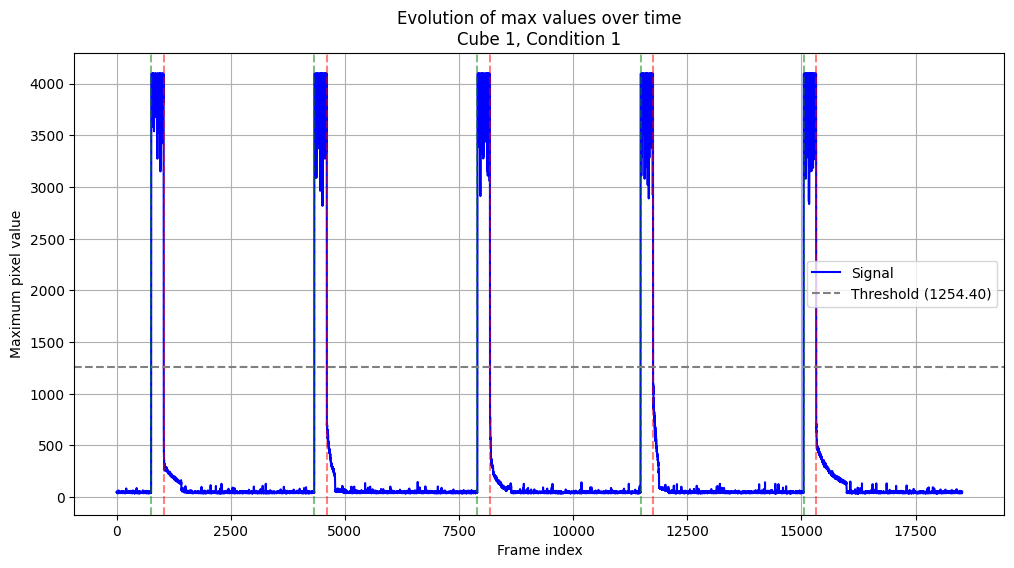

In [3]:
plot_metric(results, cube=1, condition=1, metric_name='max_values')


99th percentile: 3055.11
1st percentile: 33.00
Calculated threshold: 939.63
Found 5 segments


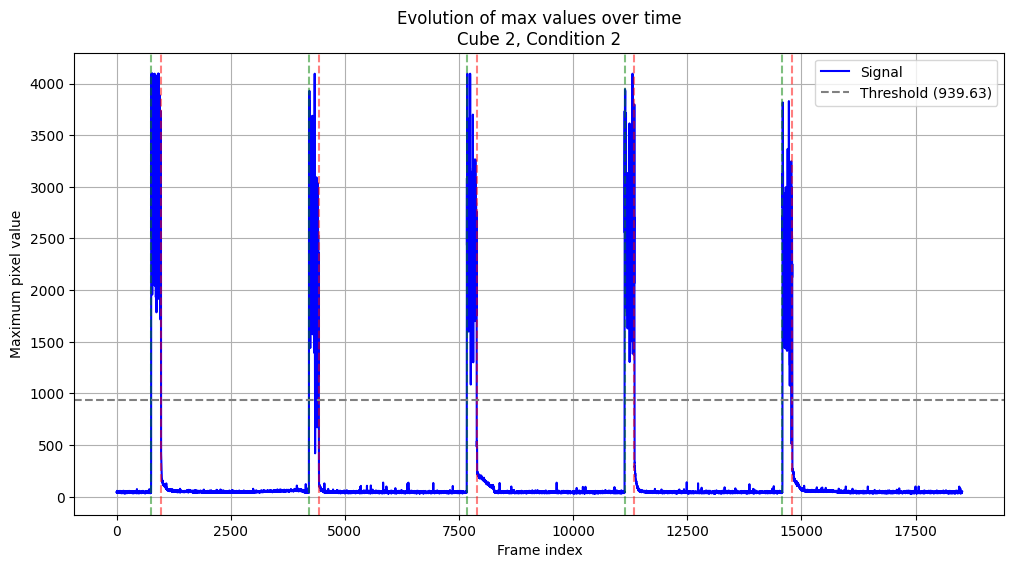

In [4]:
plot_metric(results, cube=2, condition=2, metric_name='max_values')


99th percentile: 3379.79
1st percentile: 39.00
Calculated threshold: 1041.24
Found 5 segments


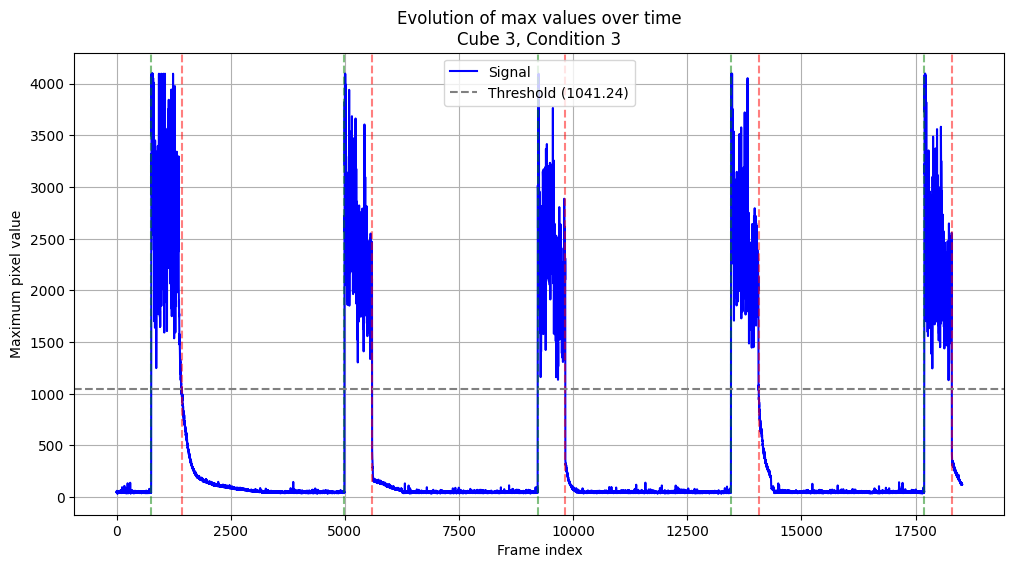

In [7]:
plot_metric(results, cube=3, condition=3, metric_name='max_values')


99th percentile: 4095.00
1st percentile: 34.00
Calculated threshold: 1252.30
Found 5 segments


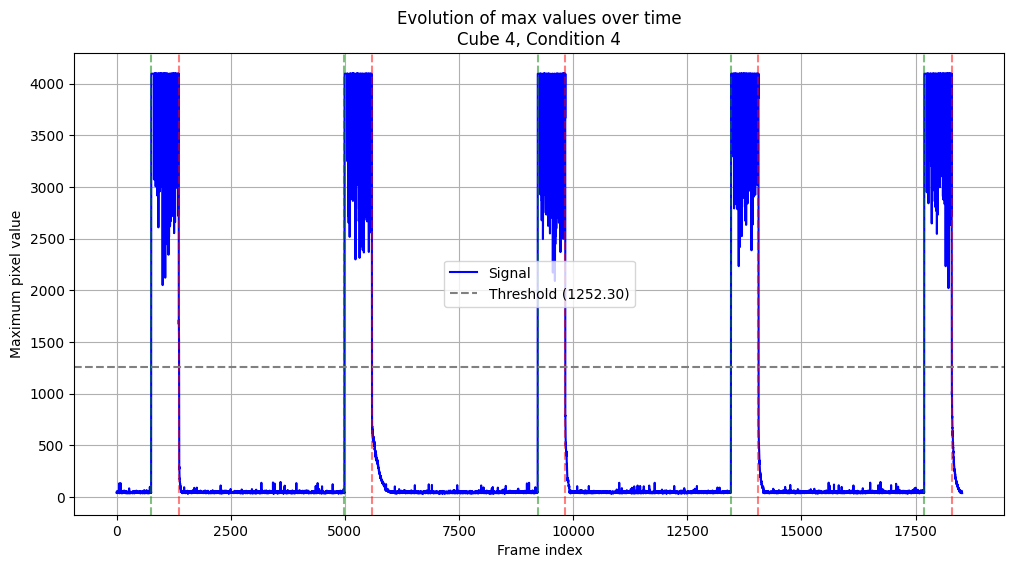

In [8]:
plot_metric(results, cube=4, condition=4, metric_name='max_values')


Plotting: Cube=1, Condition=1
99th percentile: 4095.00
1st percentile: 37.00
Calculated threshold: 1254.40
Found 5 segments


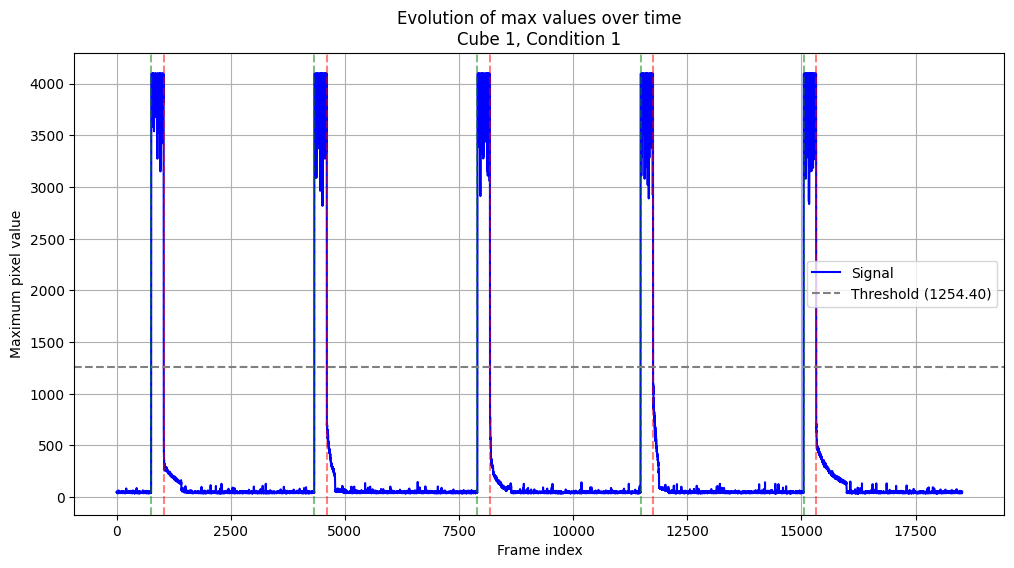

Plotting: Cube=1, Condition=2
99th percentile: 4095.00
1st percentile: 33.00
Calculated threshold: 1251.60
Found 5 segments


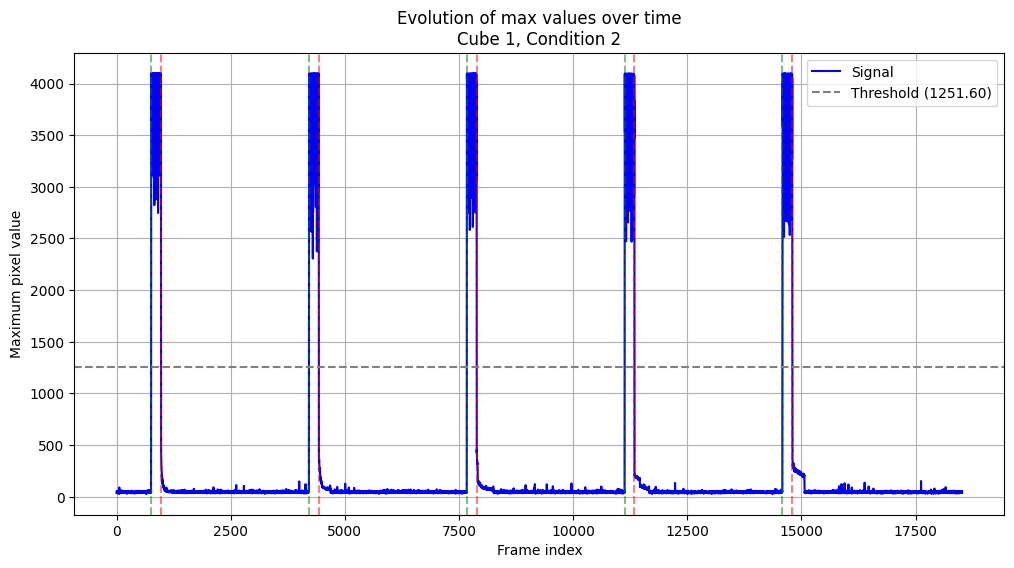

Plotting: Cube=1, Condition=3
99th percentile: 4095.00
1st percentile: 31.00
Calculated threshold: 1250.20
Found 5 segments


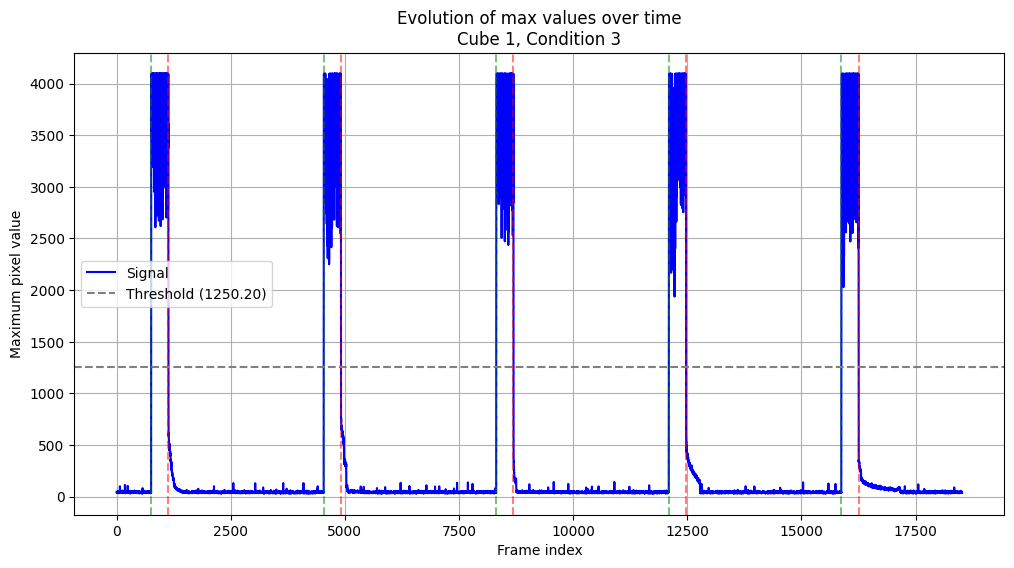

Plotting: Cube=1, Condition=4
99th percentile: 3376.58
1st percentile: 37.00
Calculated threshold: 1038.87
Found 5 segments


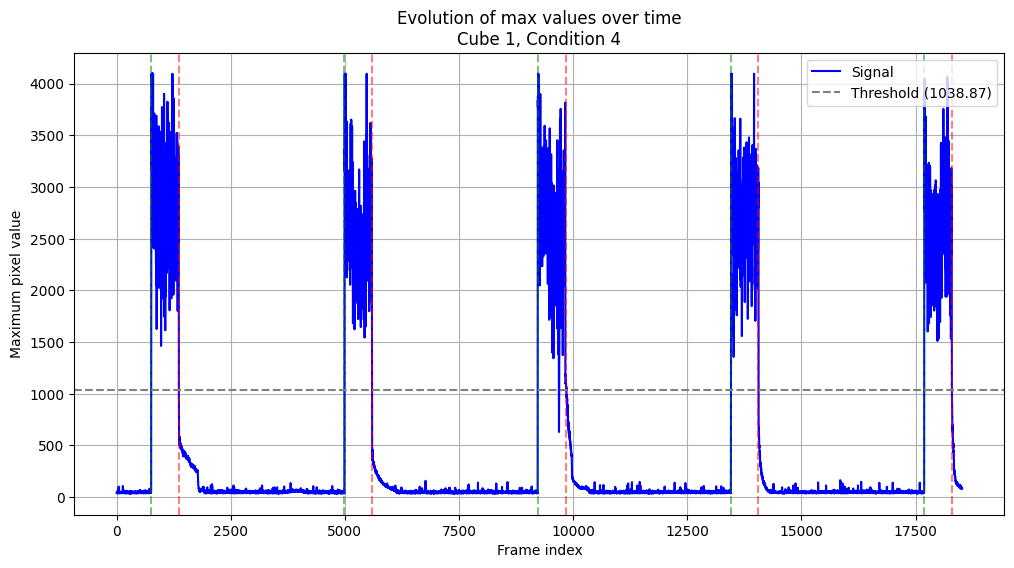

Plotting: Cube=1, Condition=5
99th percentile: 3856.00
1st percentile: 33.00
Calculated threshold: 1179.90
Found 5 segments


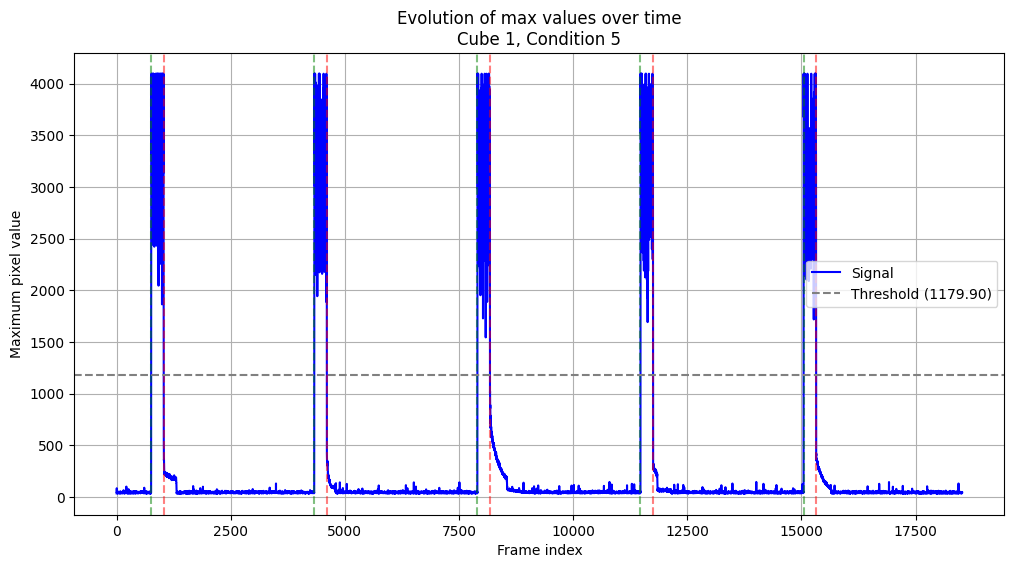

Plotting: Cube=1, Condition=6
99th percentile: 2920.37
1st percentile: 33.00
Calculated threshold: 899.21
Found 5 segments


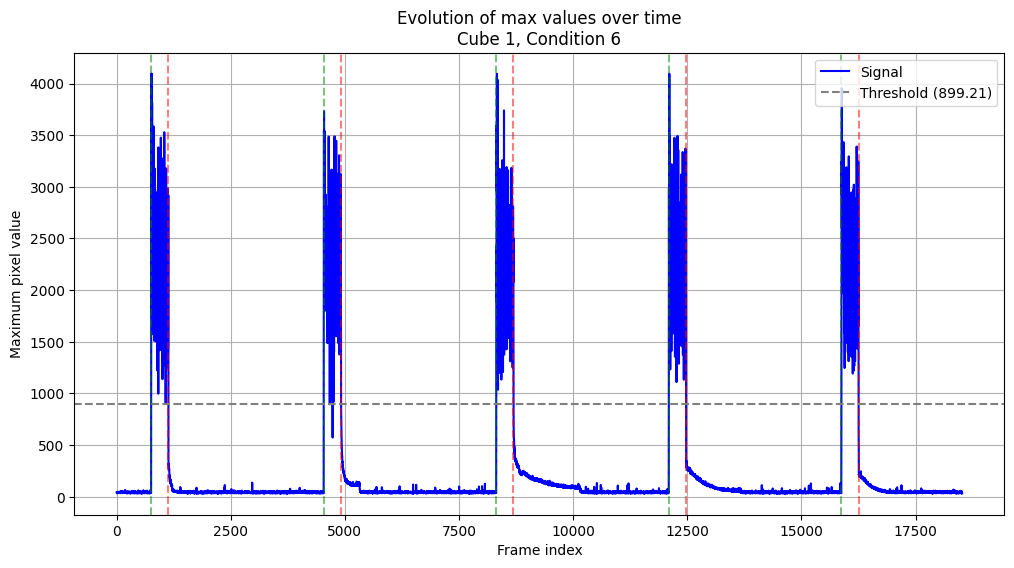

Plotting: Cube=1, Condition=7
99th percentile: 4095.00
1st percentile: 33.00
Calculated threshold: 1251.60
Found 5 segments


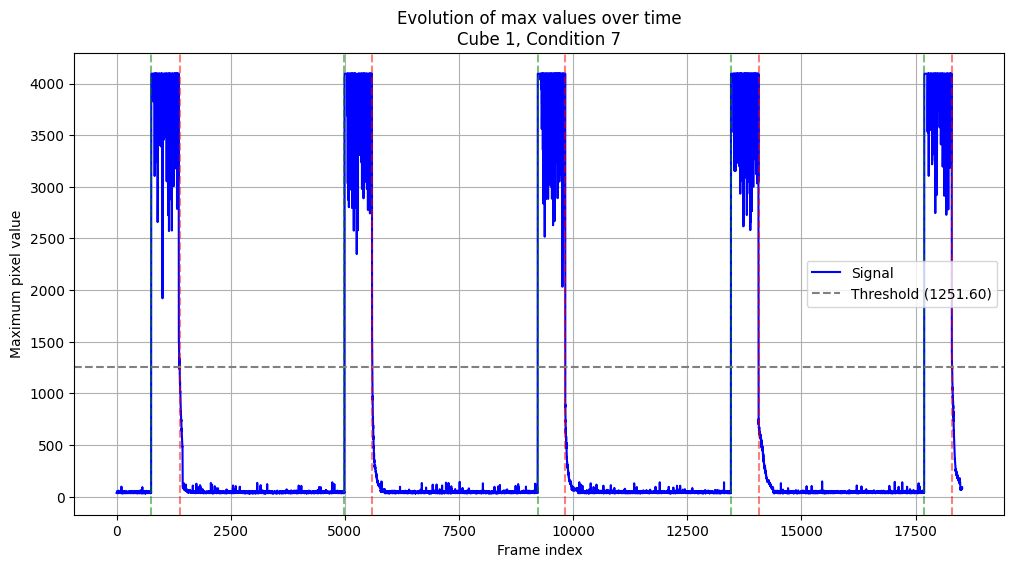

Plotting: Cube=1, Condition=8
99th percentile: 4095.00
1st percentile: 36.00
Calculated threshold: 1253.70
Found 5 segments


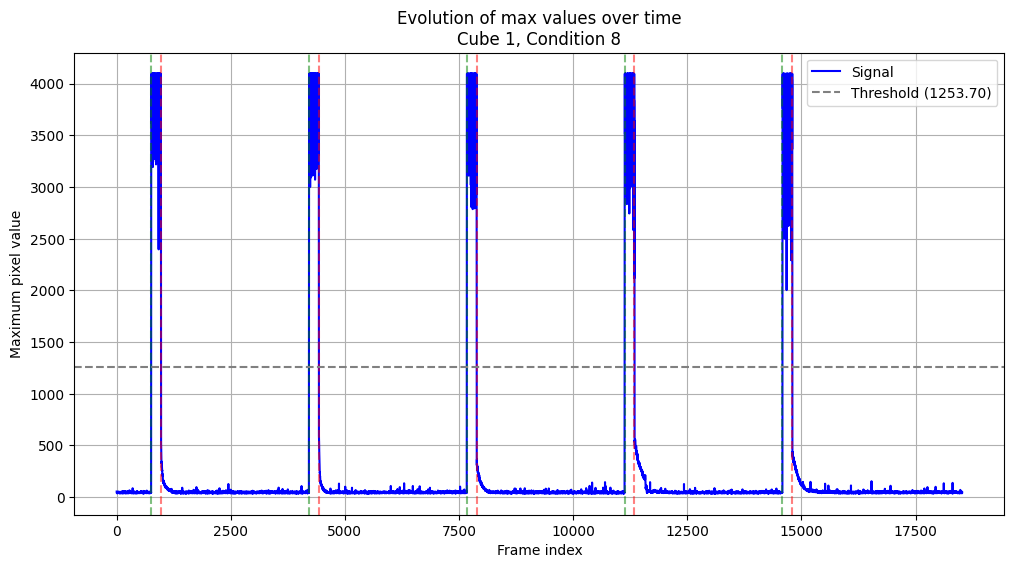

Plotting: Cube=1, Condition=9
99th percentile: 2955.79
1st percentile: 37.00
Calculated threshold: 912.64
Found 5 segments


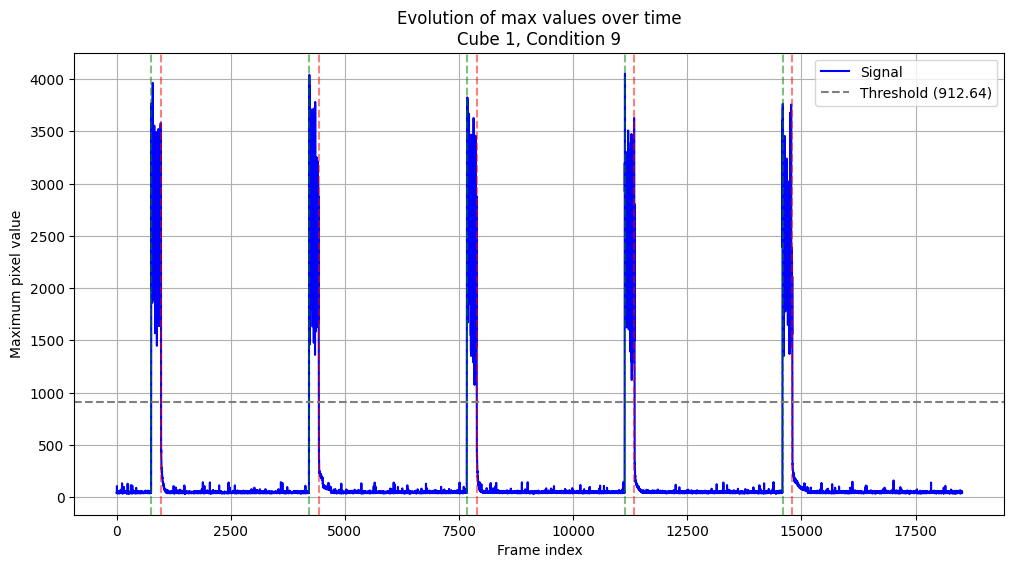

Plotting: Cube=1, Condition=10
99th percentile: 3128.00
1st percentile: 36.00
Calculated threshold: 963.60
Found 5 segments


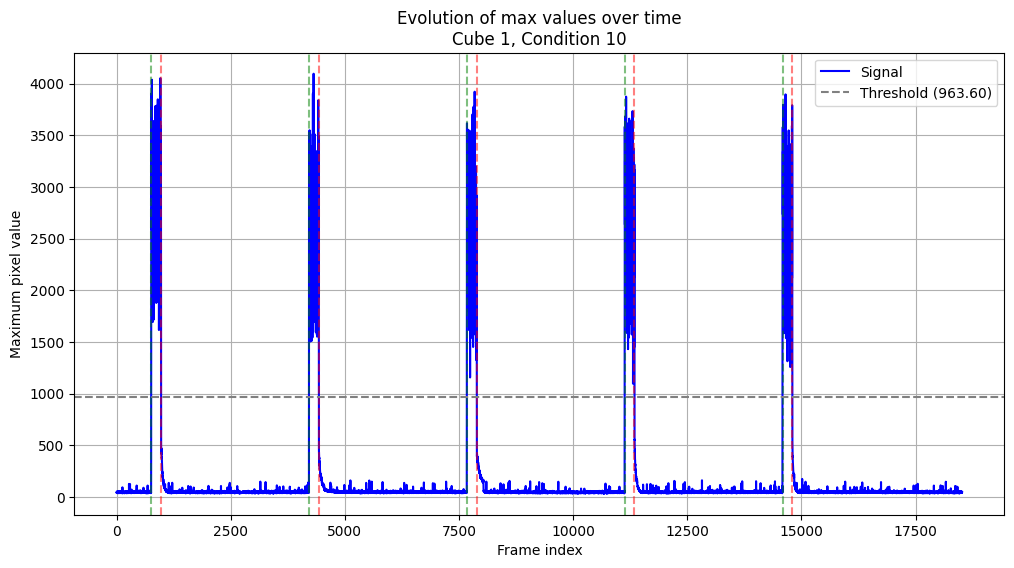

Plotting: Cube=1, Condition=11
99th percentile: 2304.79
1st percentile: 35.00
Calculated threshold: 715.94
Found 5 segments


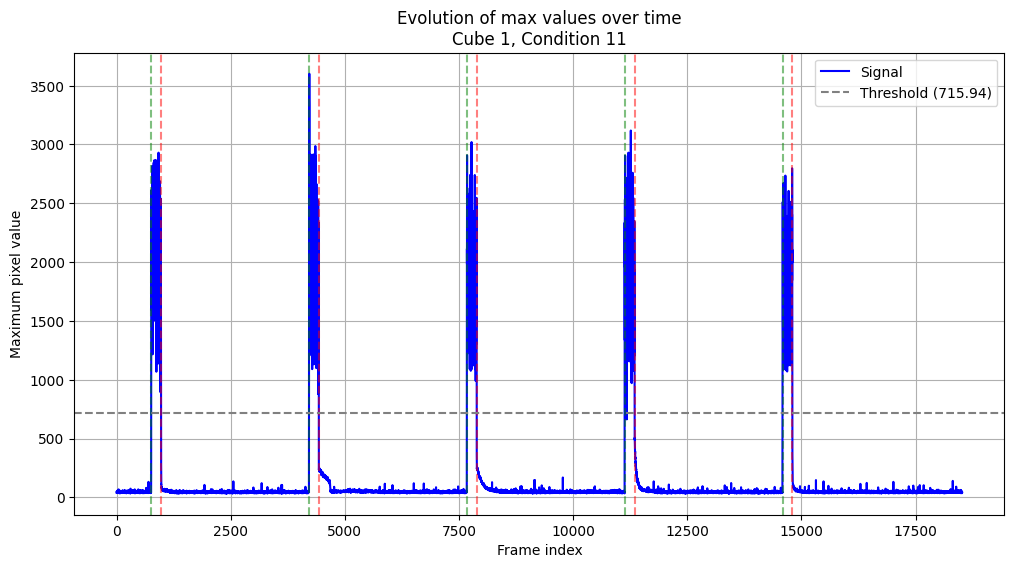

Plotting: Cube=1, Condition=12
99th percentile: 1904.74
1st percentile: 35.00
Calculated threshold: 595.92
Found 5 segments


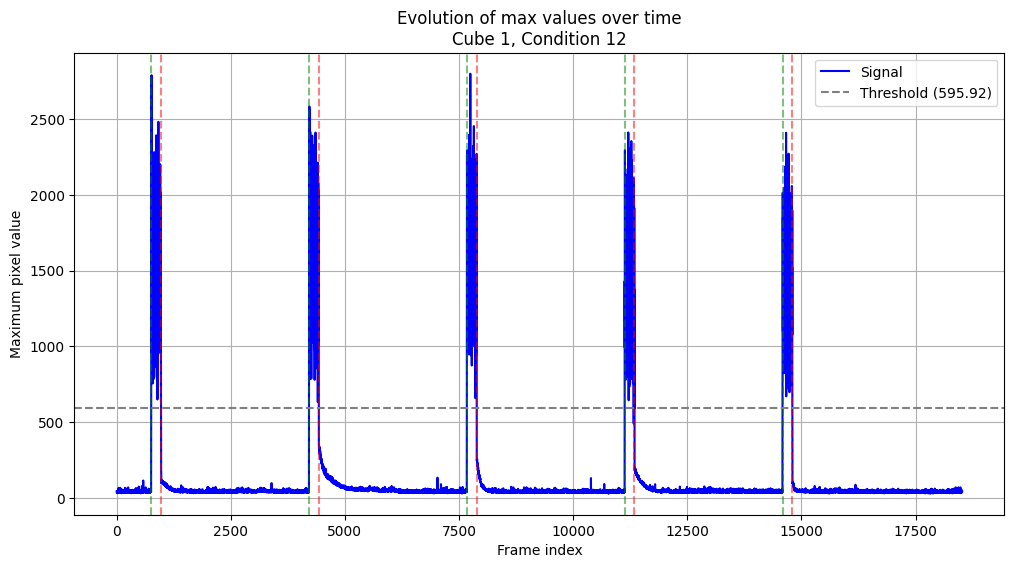

Plotting: Cube=2, Condition=1
99th percentile: 4095.00
1st percentile: 38.00
Calculated threshold: 1255.10
Found 4 segments


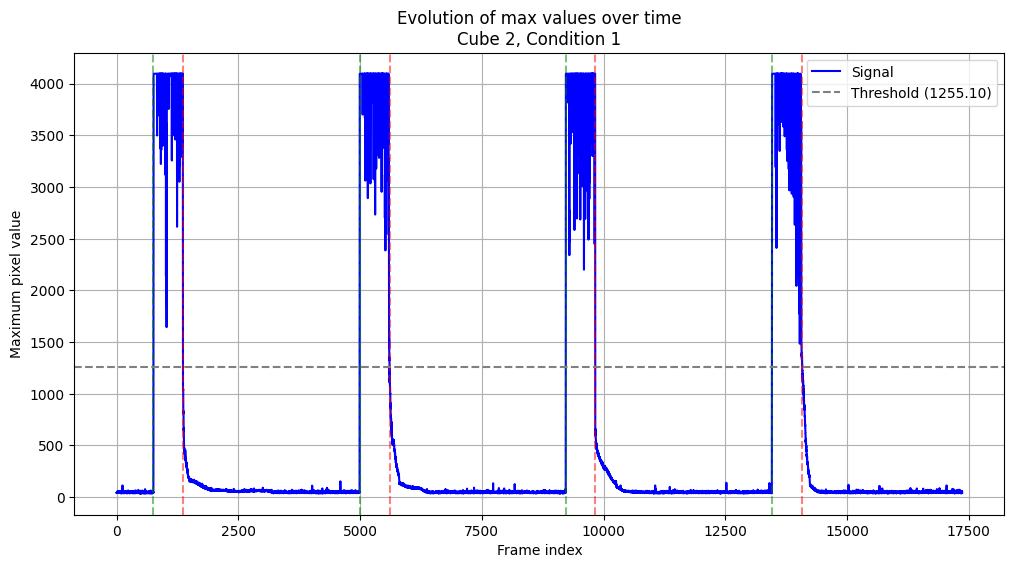

Plotting: Cube=2, Condition=2
99th percentile: 3055.11
1st percentile: 33.00
Calculated threshold: 939.63
Found 5 segments


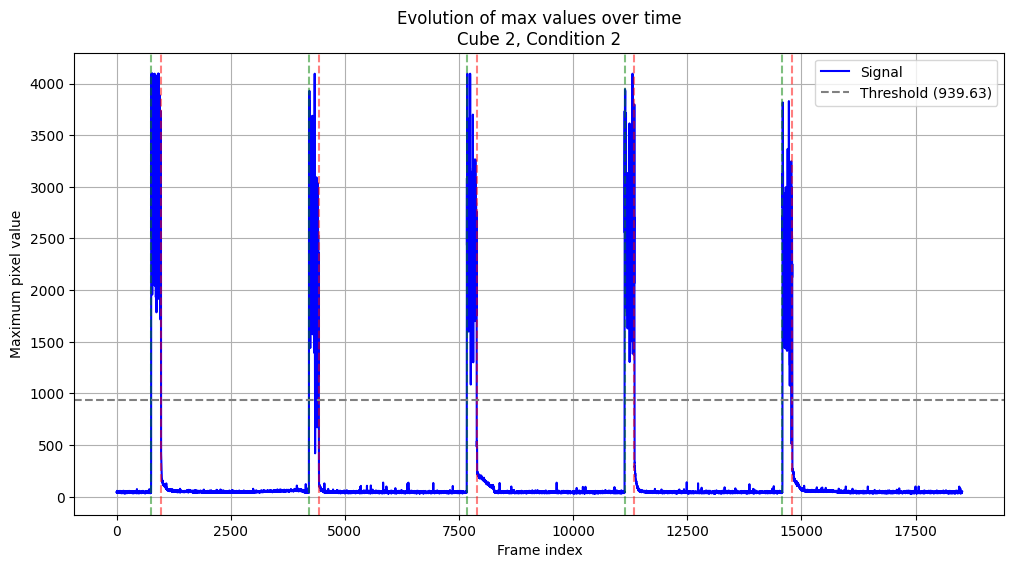

Plotting: Cube=2, Condition=3
99th percentile: 3082.74
1st percentile: 37.00
Calculated threshold: 950.72
Found 5 segments


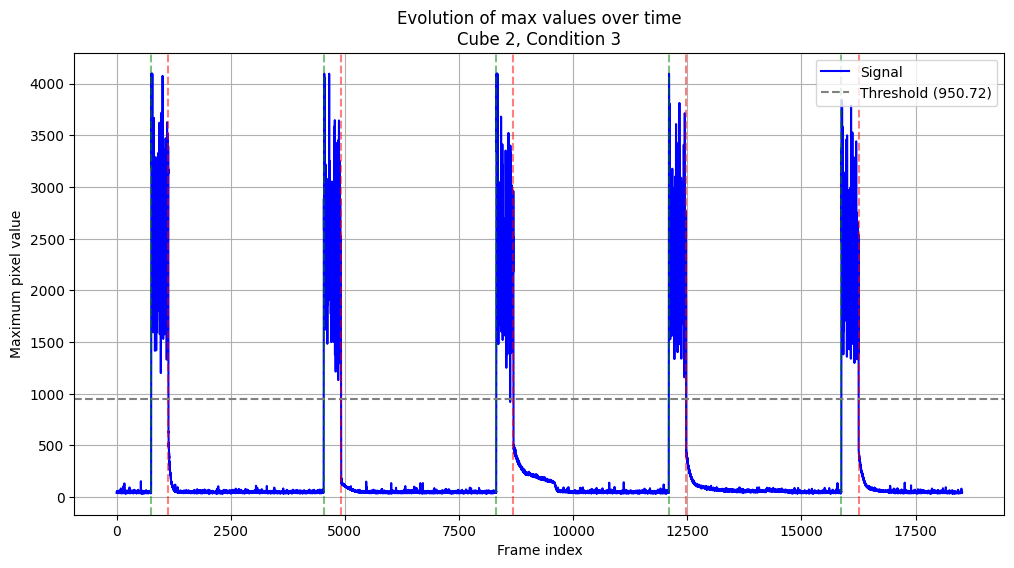

Plotting: Cube=2, Condition=4
99th percentile: 1838.79
1st percentile: 37.00
Calculated threshold: 577.54
Found 5 segments


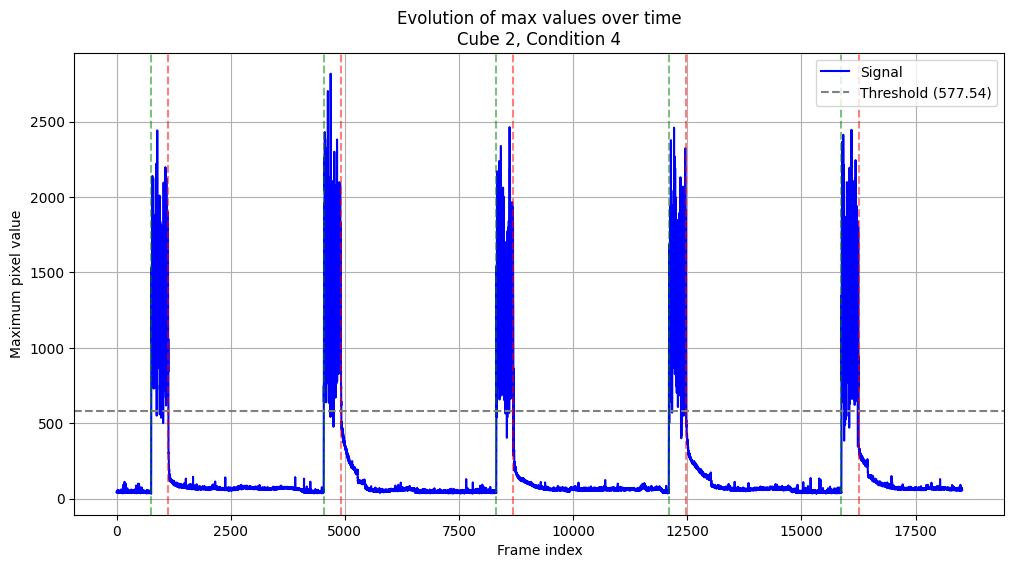

Plotting: Cube=2, Condition=5
99th percentile: 3538.16
1st percentile: 34.00
Calculated threshold: 1085.25
Found 5 segments


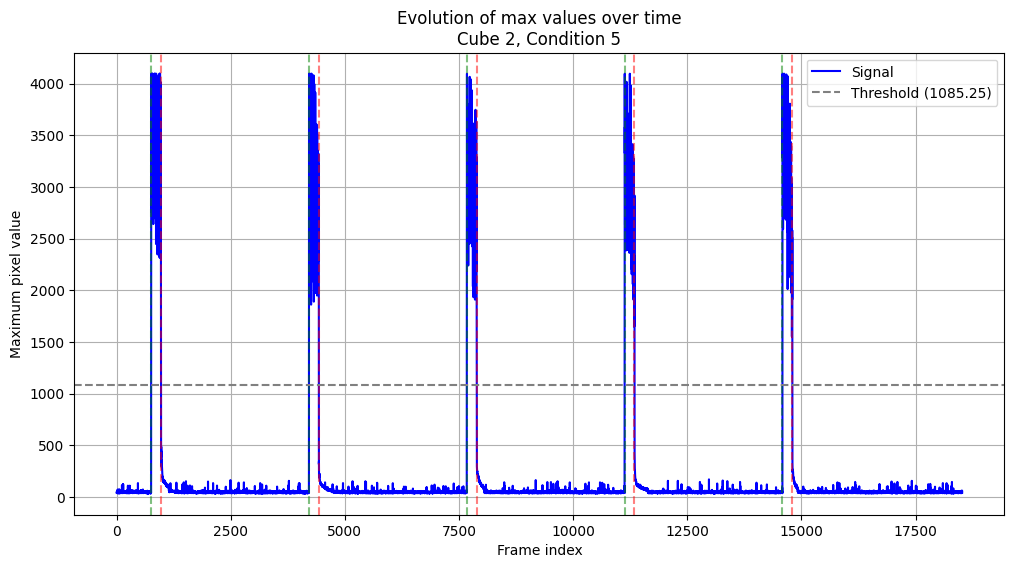

Plotting: Cube=2, Condition=6
99th percentile: 1750.58
1st percentile: 36.00
Calculated threshold: 550.37
Found 5 segments


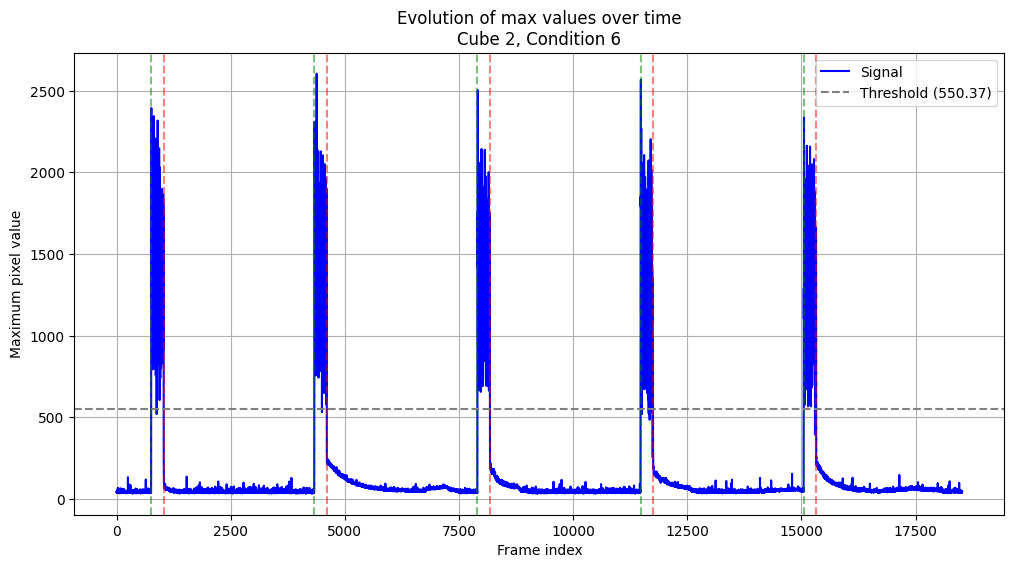

Plotting: Cube=2, Condition=7
99th percentile: 856.00
1st percentile: 36.00
Calculated threshold: 282.00
Found 5 segments


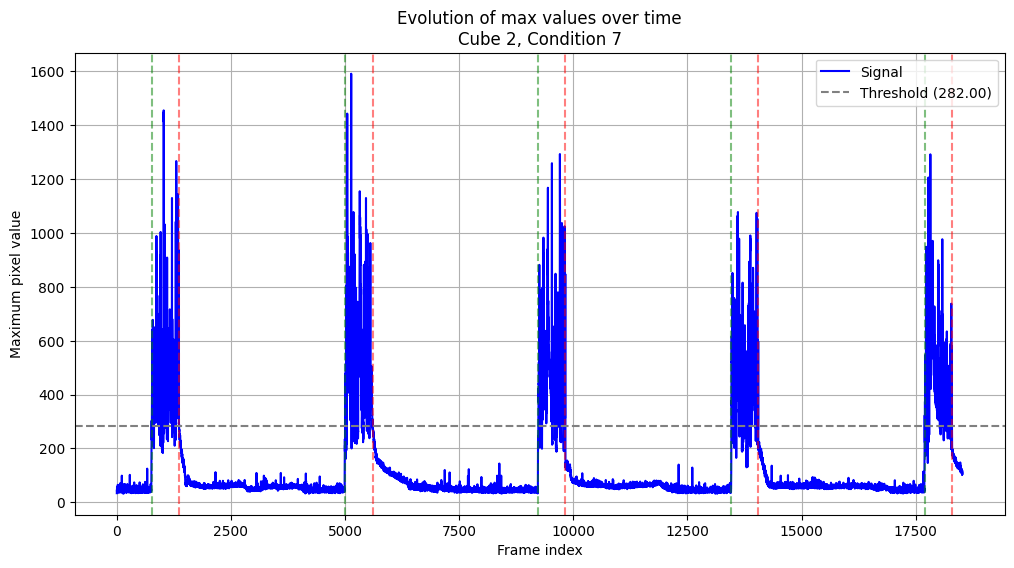

Plotting: Cube=2, Condition=8
99th percentile: 3118.79
1st percentile: 35.00
Calculated threshold: 960.14
Found 5 segments


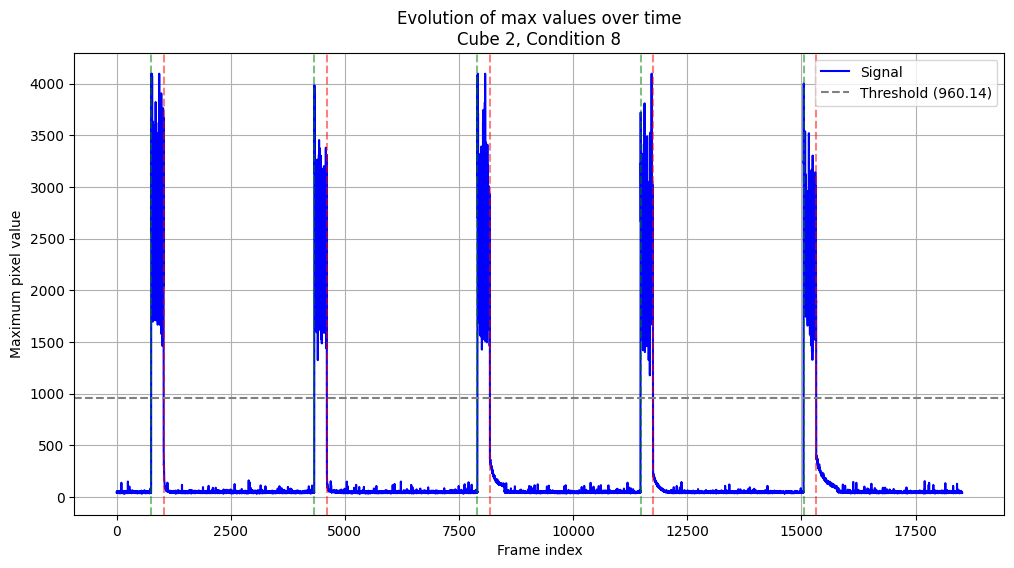

Plotting: Cube=2, Condition=9
99th percentile: 4095.00
1st percentile: 36.00
Calculated threshold: 1253.70
Found 5 segments


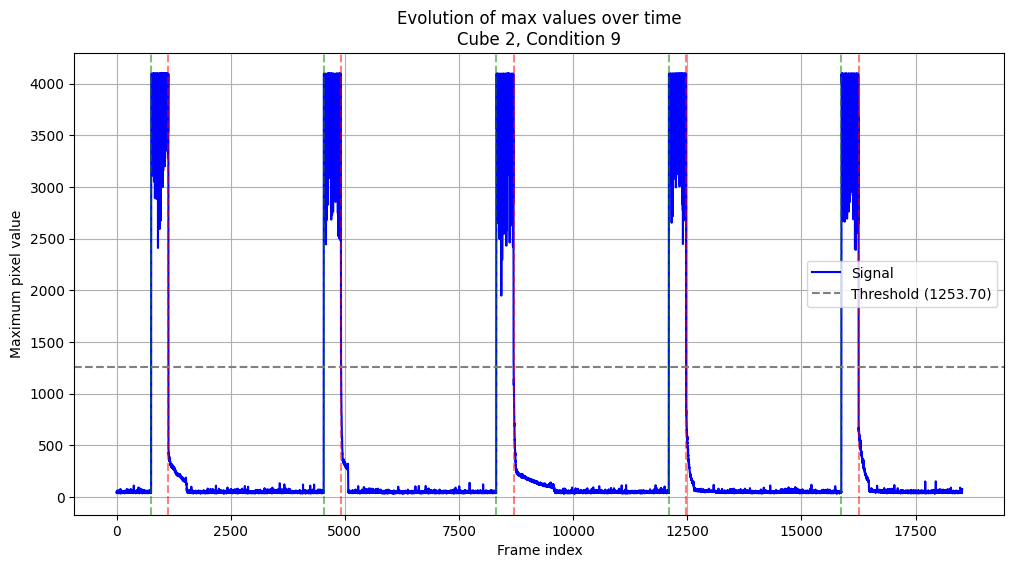

Plotting: Cube=2, Condition=10
99th percentile: 2682.79
1st percentile: 33.00
Calculated threshold: 827.94
Found 5 segments


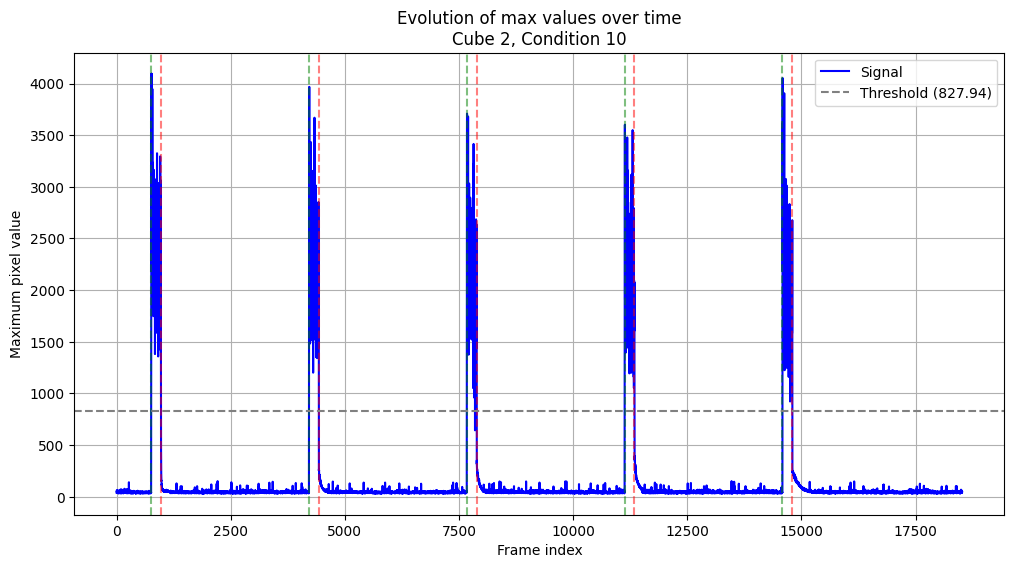

Plotting: Cube=2, Condition=11
99th percentile: 4095.00
1st percentile: 36.00
Calculated threshold: 1253.70
Found 5 segments


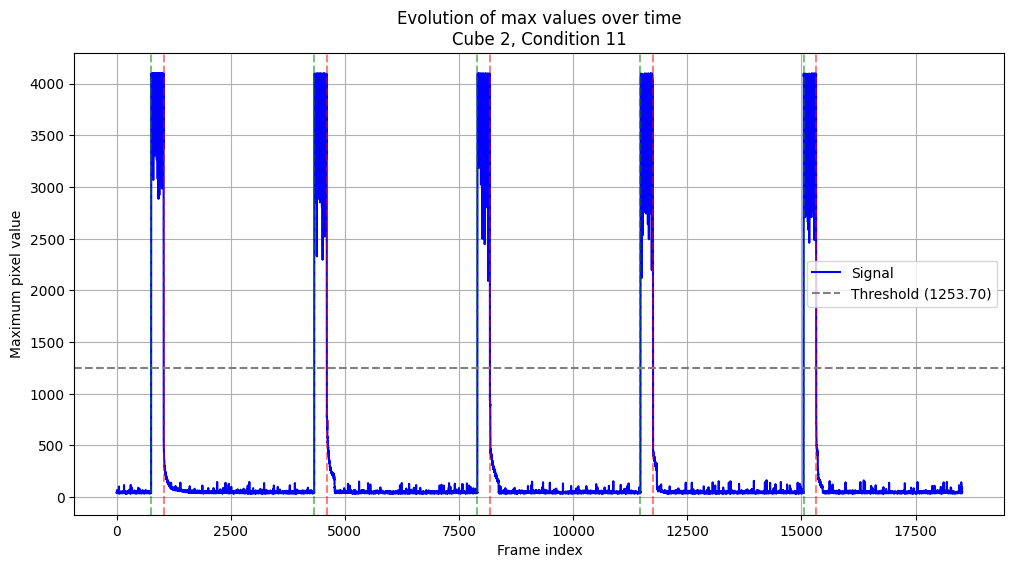

Plotting: Cube=2, Condition=12
99th percentile: 1705.00
1st percentile: 34.00
Calculated threshold: 535.30
Found 5 segments


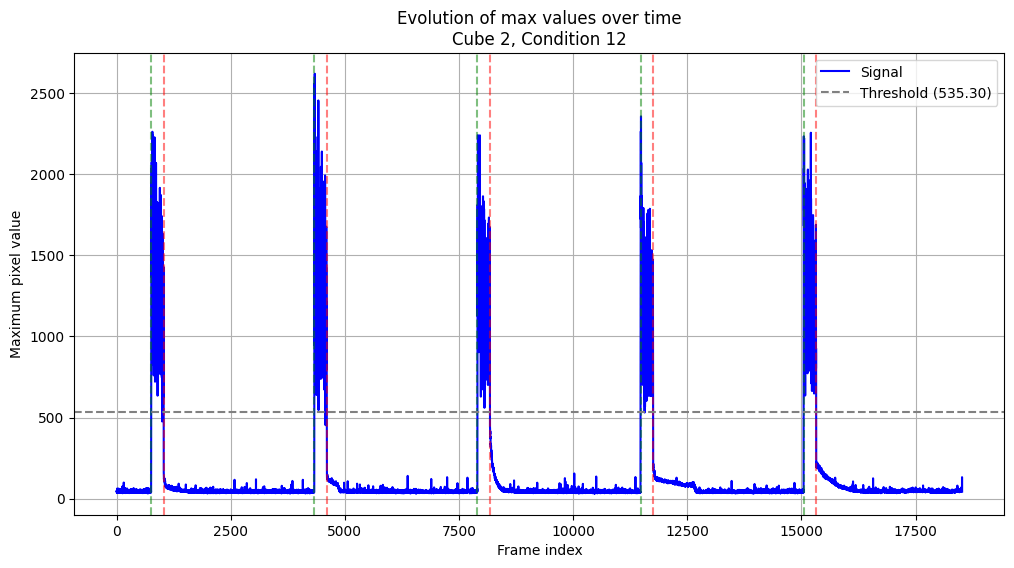

Plotting: Cube=3, Condition=1
99th percentile: 4095.00
1st percentile: 38.00
Calculated threshold: 1255.10
Found 5 segments


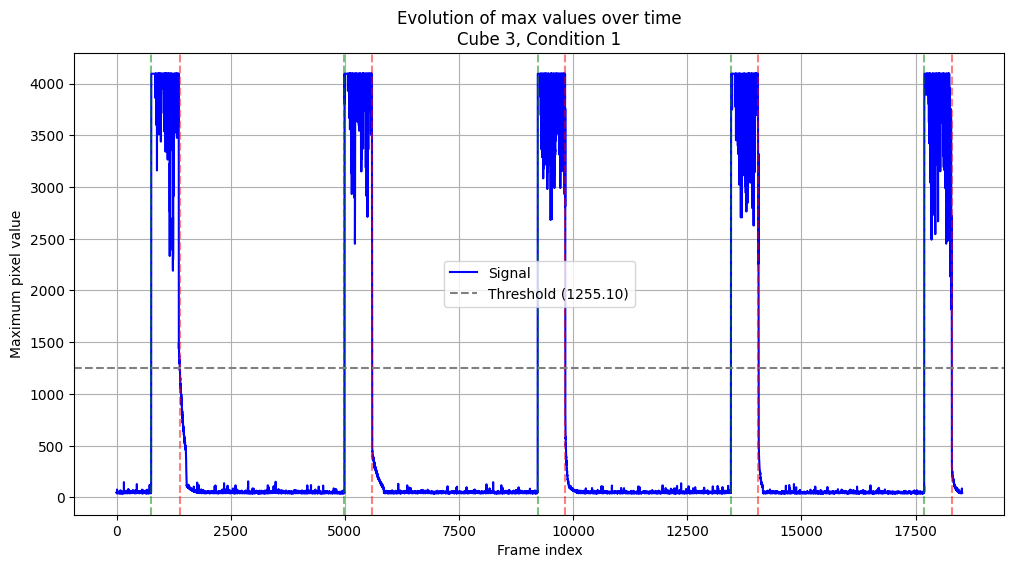

Plotting: Cube=3, Condition=2
99th percentile: 1287.00
1st percentile: 38.00
Calculated threshold: 412.70
Found 5 segments


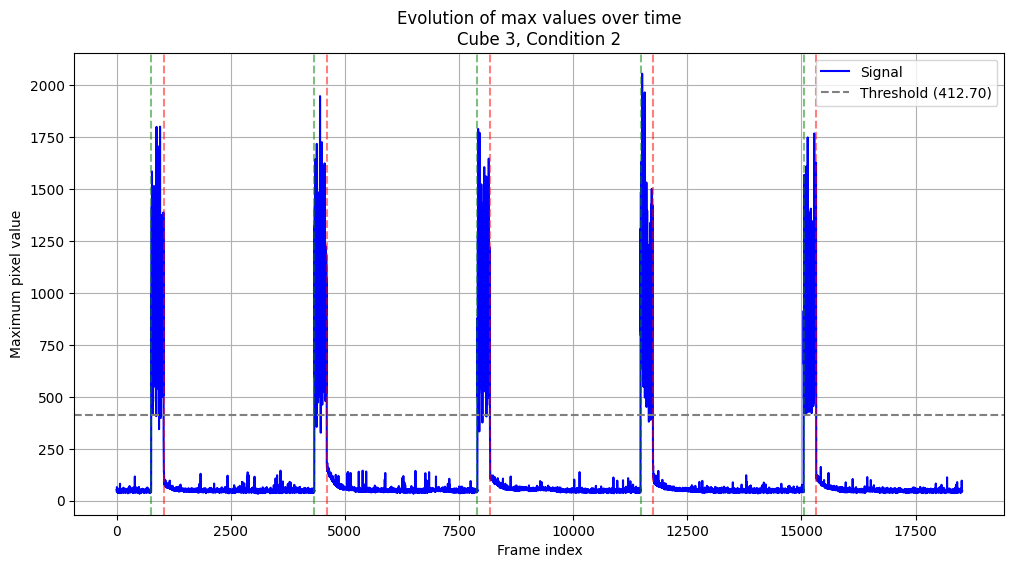

Plotting: Cube=3, Condition=3
99th percentile: 3379.79
1st percentile: 39.00
Calculated threshold: 1041.24
Found 5 segments


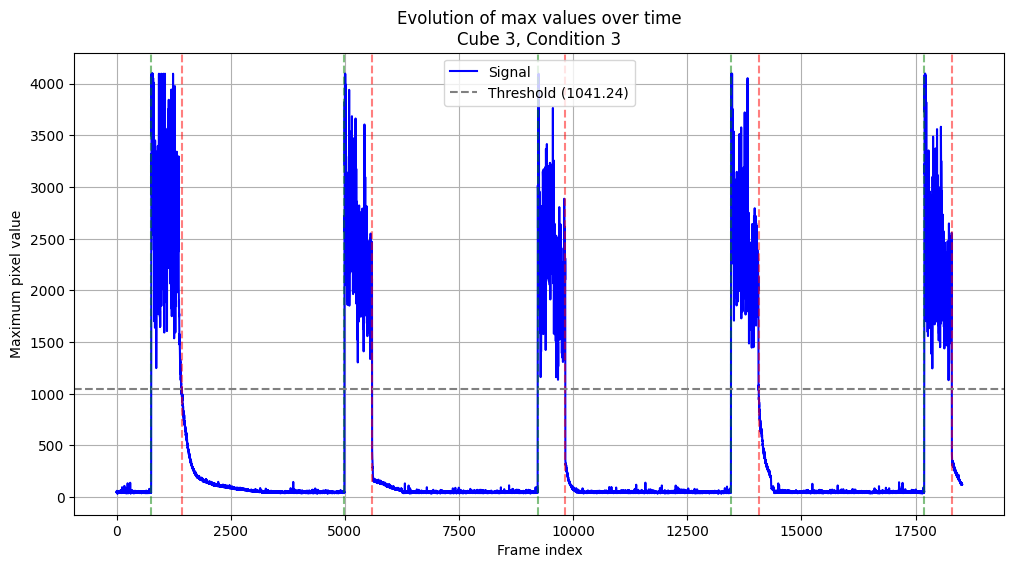

Plotting: Cube=3, Condition=4
99th percentile: 4095.00
1st percentile: 40.00
Calculated threshold: 1256.50
Found 5 segments


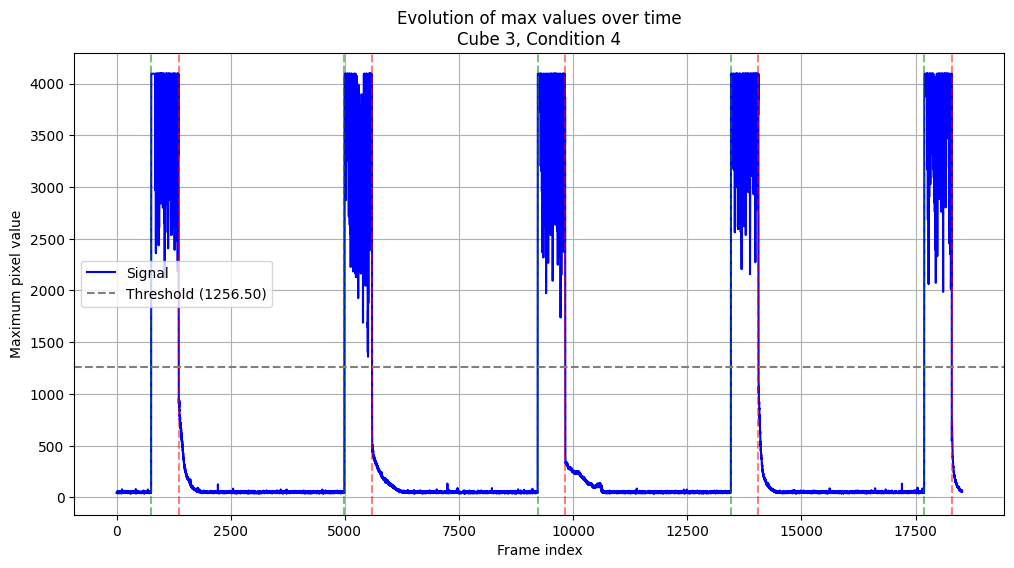

Plotting: Cube=3, Condition=5
99th percentile: 2730.58
1st percentile: 37.00
Calculated threshold: 845.07
Found 5 segments


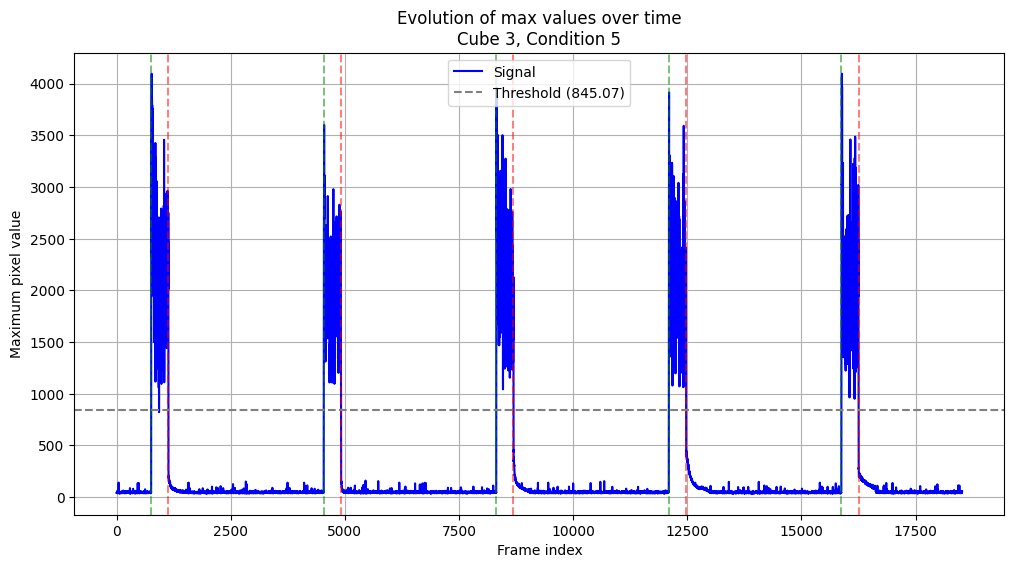

Plotting: Cube=3, Condition=6
99th percentile: 1345.79
1st percentile: 36.00
Calculated threshold: 428.94
Found 5 segments


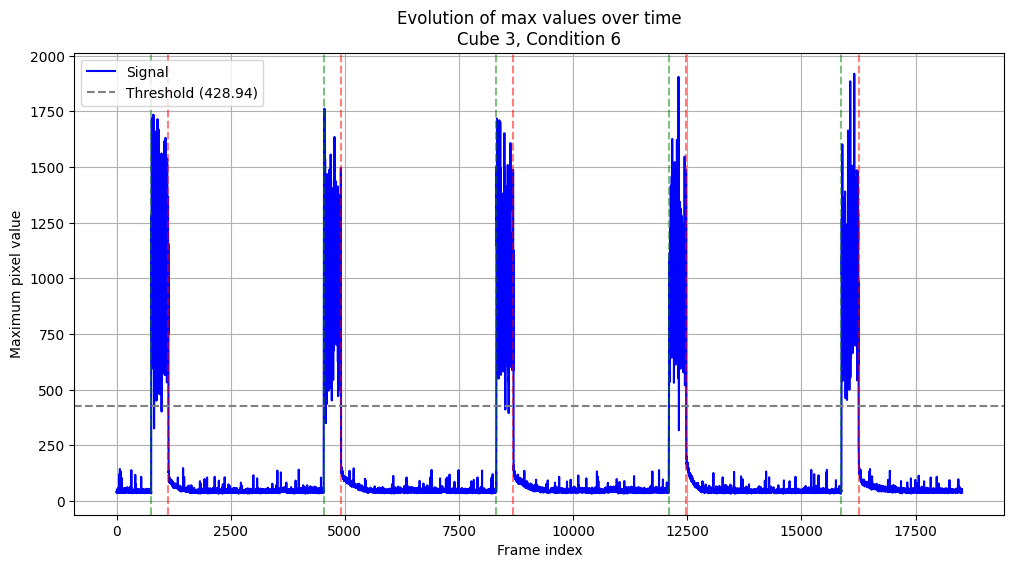

Plotting: Cube=3, Condition=7
99th percentile: 3607.48
1st percentile: 36.00
Calculated threshold: 1107.44
Found 5 segments


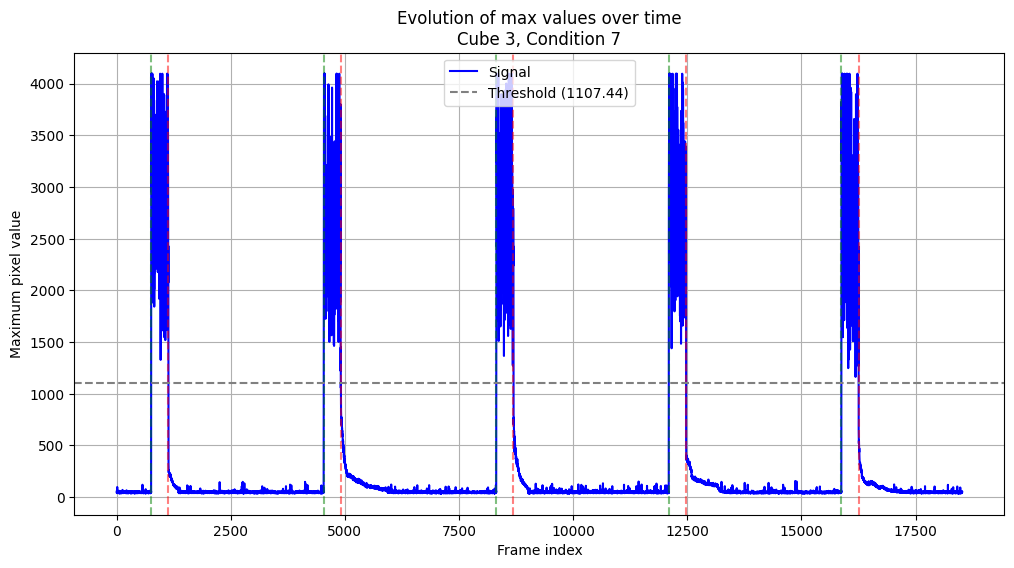

Plotting: Cube=3, Condition=8
99th percentile: 1444.00
1st percentile: 41.00
Calculated threshold: 461.90
Found 5 segments


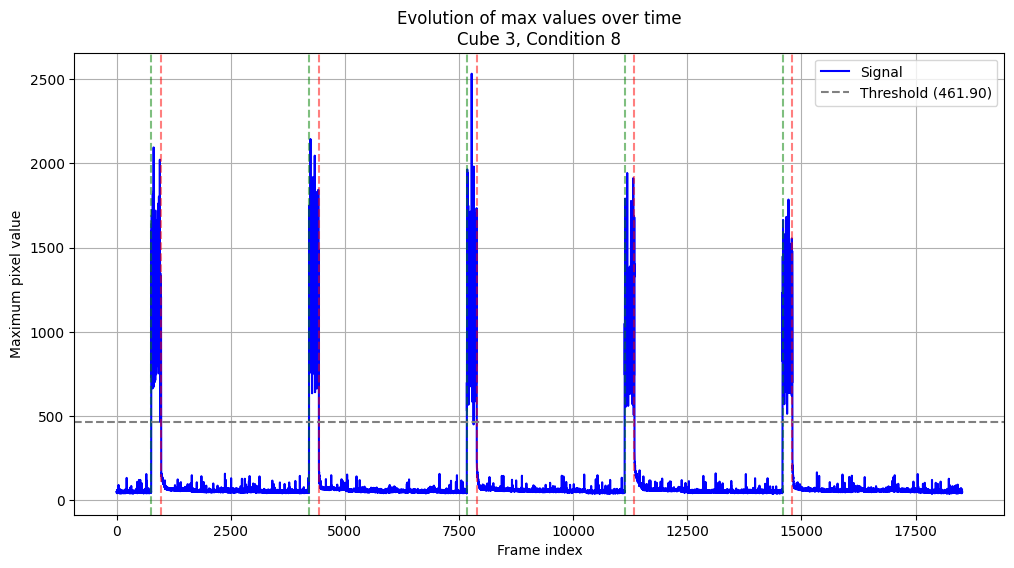

Plotting: Cube=3, Condition=9
99th percentile: 2878.95
1st percentile: 39.00
Calculated threshold: 890.99
Found 5 segments


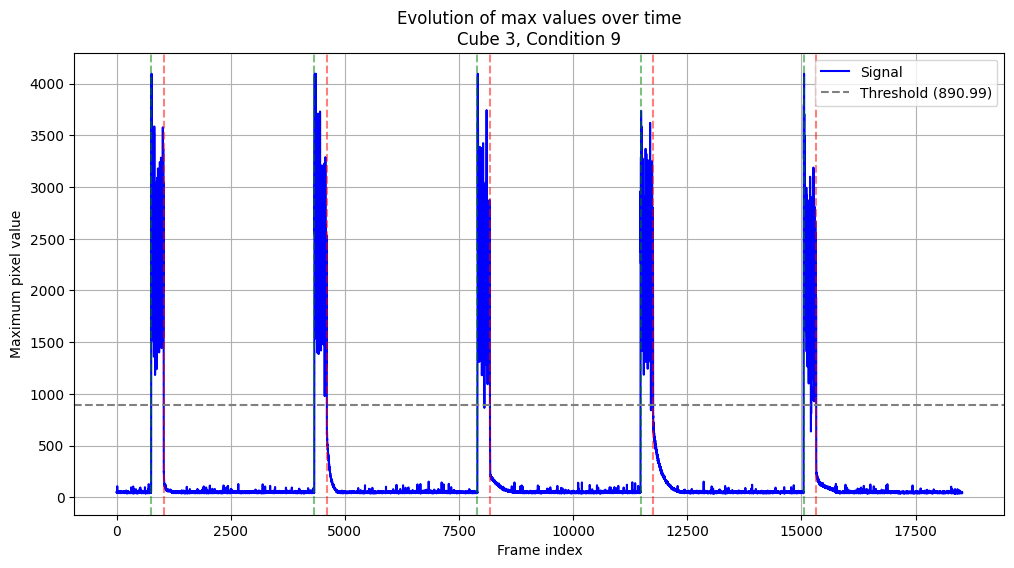

Plotting: Cube=3, Condition=10
99th percentile: 2933.58
1st percentile: 40.00
Calculated threshold: 908.07
Found 5 segments


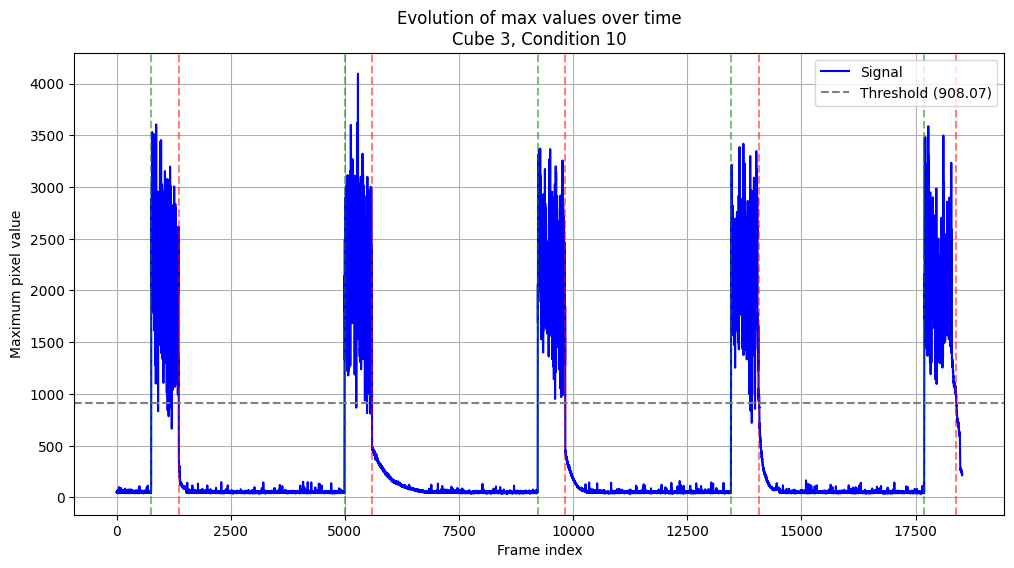

Plotting: Cube=3, Condition=11
99th percentile: 4095.00
1st percentile: 40.00
Calculated threshold: 1256.50
Found 5 segments


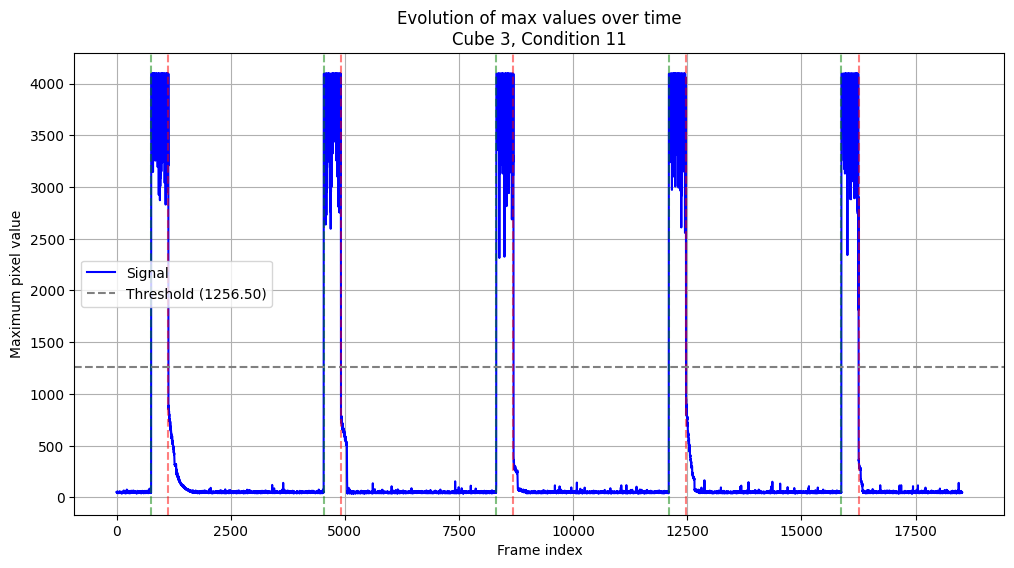

Plotting: Cube=3, Condition=12
99th percentile: 3031.37
1st percentile: 34.00
Calculated threshold: 933.21
Found 5 segments


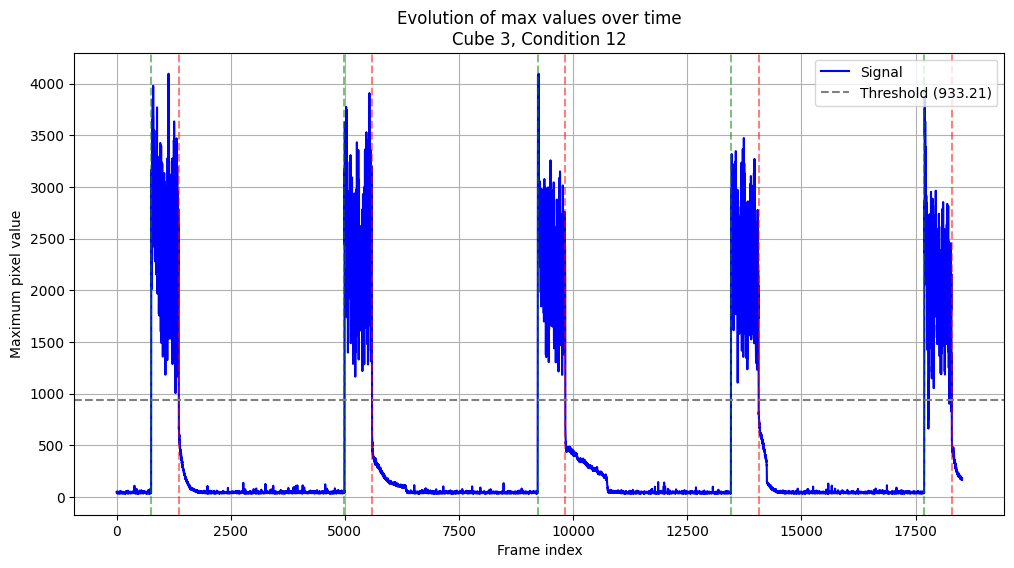

Plotting: Cube=4, Condition=1
99th percentile: 4095.00
1st percentile: 37.00
Calculated threshold: 1254.40
Found 5 segments


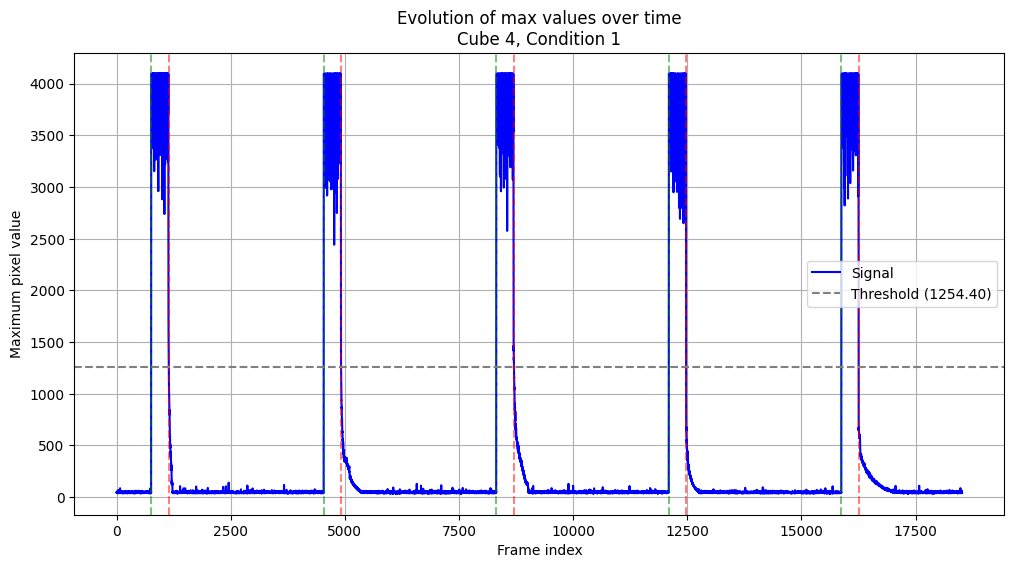

Plotting: Cube=4, Condition=2
99th percentile: 4095.00
1st percentile: 35.00
Calculated threshold: 1253.00
Found 5 segments


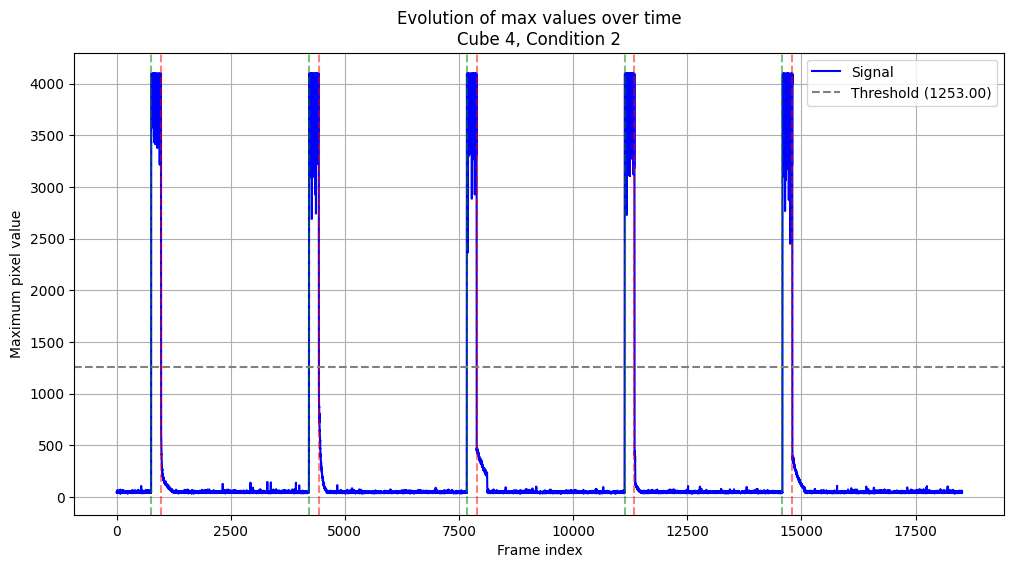

Plotting: Cube=4, Condition=3
99th percentile: 2465.00
1st percentile: 39.00
Calculated threshold: 766.80
Found 5 segments


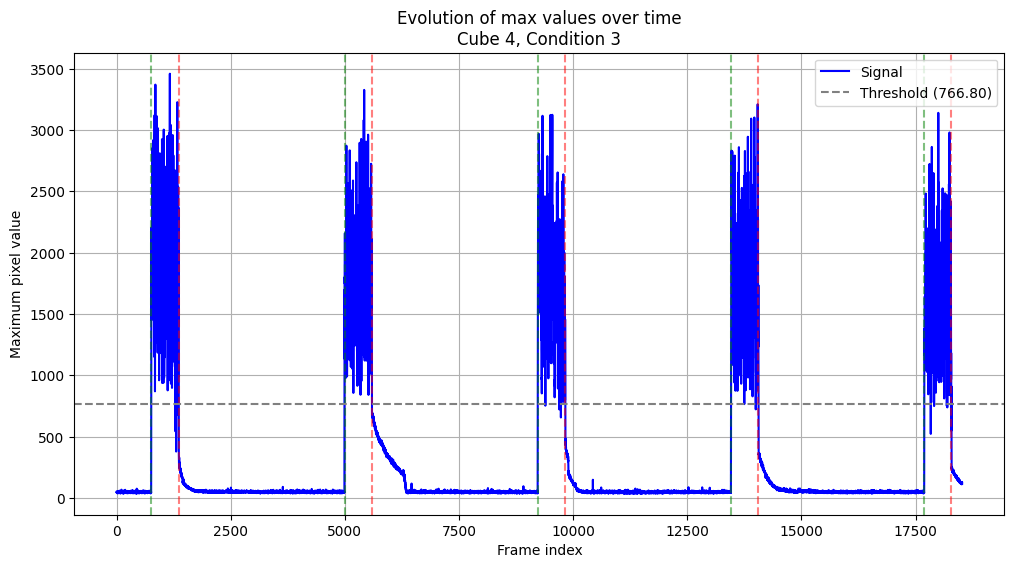

Plotting: Cube=4, Condition=4
99th percentile: 4095.00
1st percentile: 34.00
Calculated threshold: 1252.30
Found 5 segments


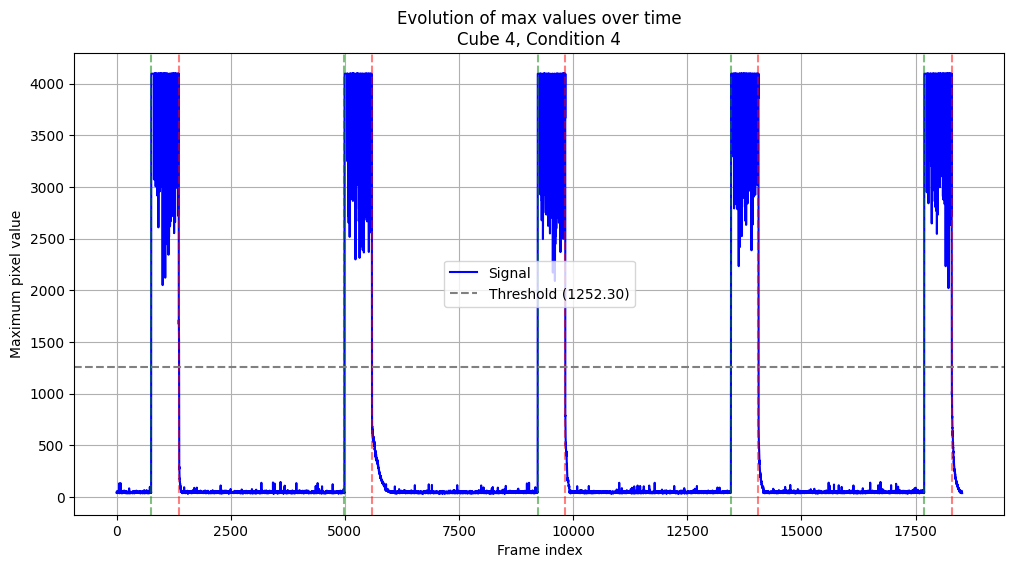

Plotting: Cube=4, Condition=5
99th percentile: 1419.79
1st percentile: 35.00
Calculated threshold: 450.44
Found 5 segments


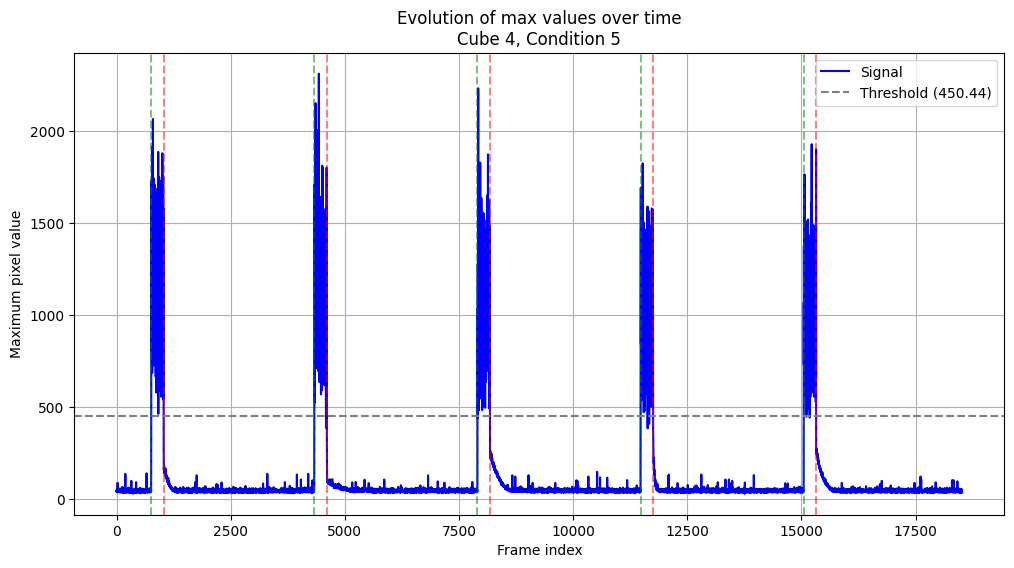

Plotting: Cube=4, Condition=6
99th percentile: 1294.58
1st percentile: 37.00
Calculated threshold: 414.27
Found 5 segments


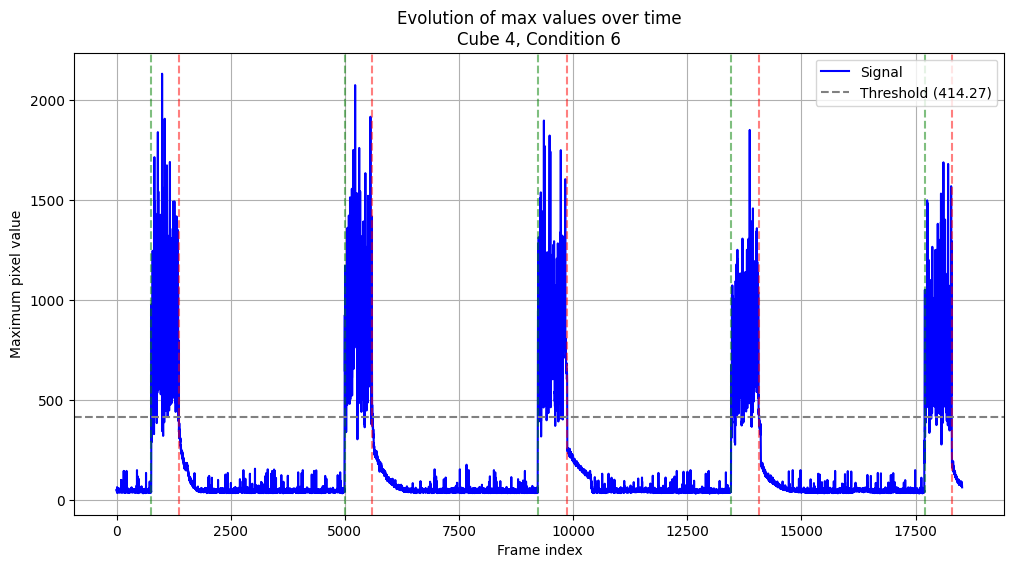

Plotting: Cube=4, Condition=7
99th percentile: 4095.00
1st percentile: 38.00
Calculated threshold: 1255.10
Found 5 segments


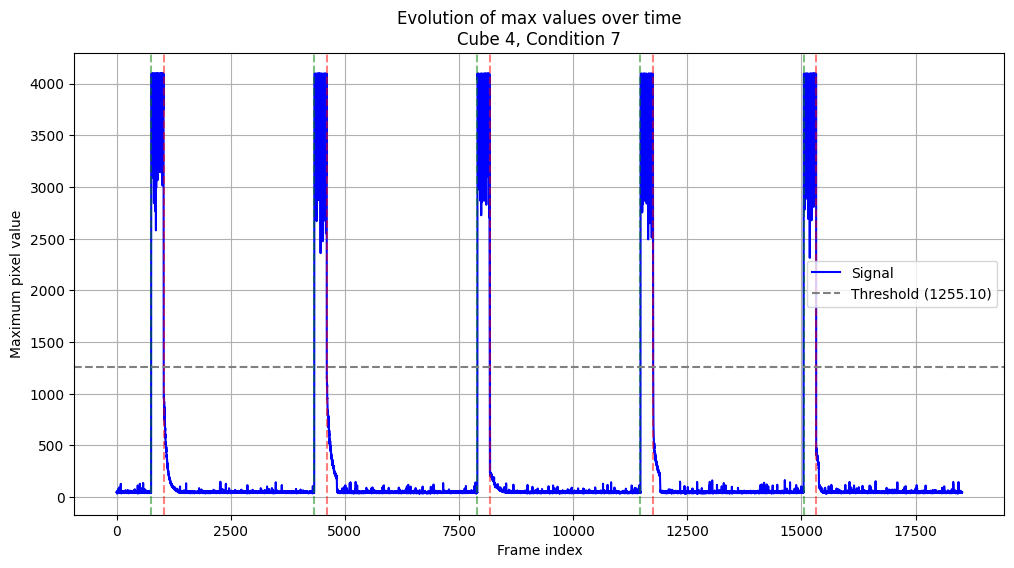

Plotting: Cube=4, Condition=8
99th percentile: 4095.00
1st percentile: 38.00
Calculated threshold: 1255.10
Found 5 segments


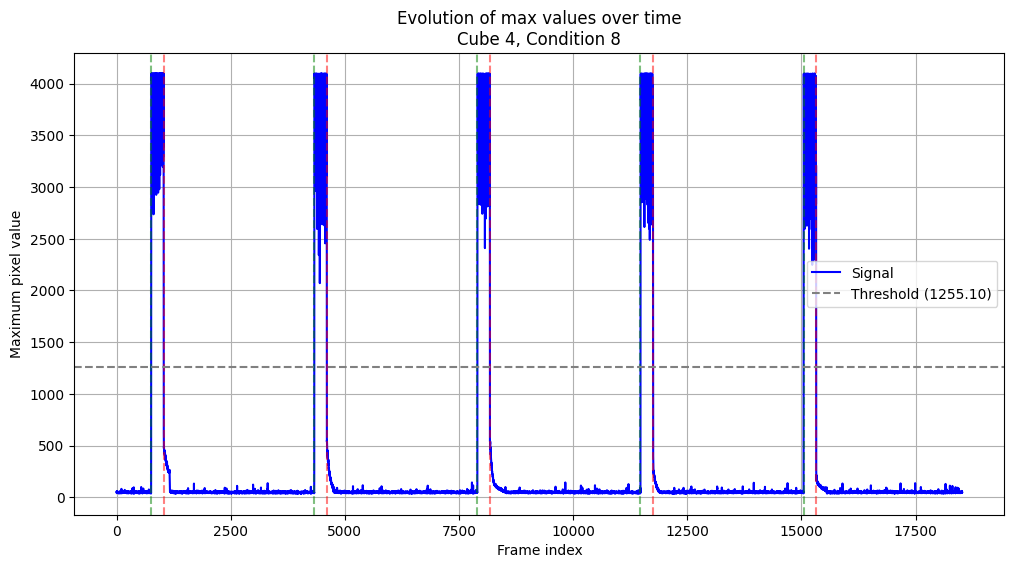

Plotting: Cube=4, Condition=9
99th percentile: 2803.79
1st percentile: 39.00
Calculated threshold: 868.44
Found 5 segments


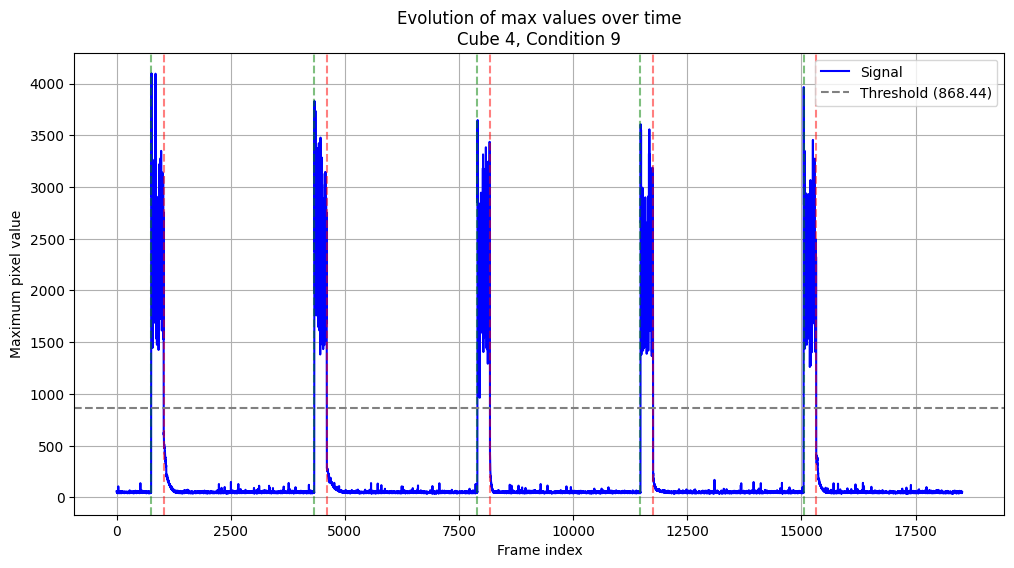

Plotting: Cube=4, Condition=10
99th percentile: 2868.79
1st percentile: 39.00
Calculated threshold: 887.94
Found 5 segments


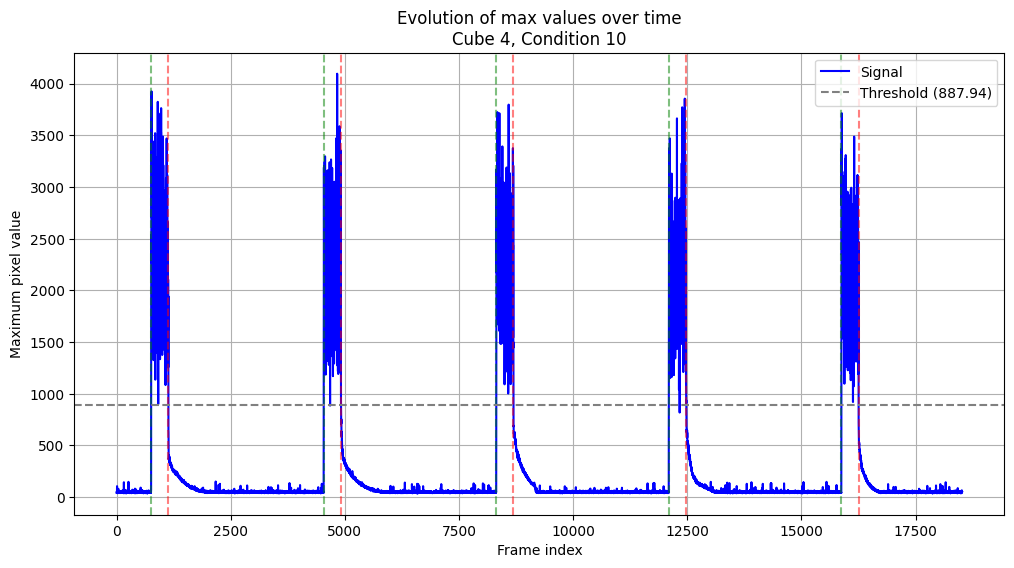

Plotting: Cube=4, Condition=11
99th percentile: 1793.95
1st percentile: 37.00
Calculated threshold: 564.09
Found 5 segments


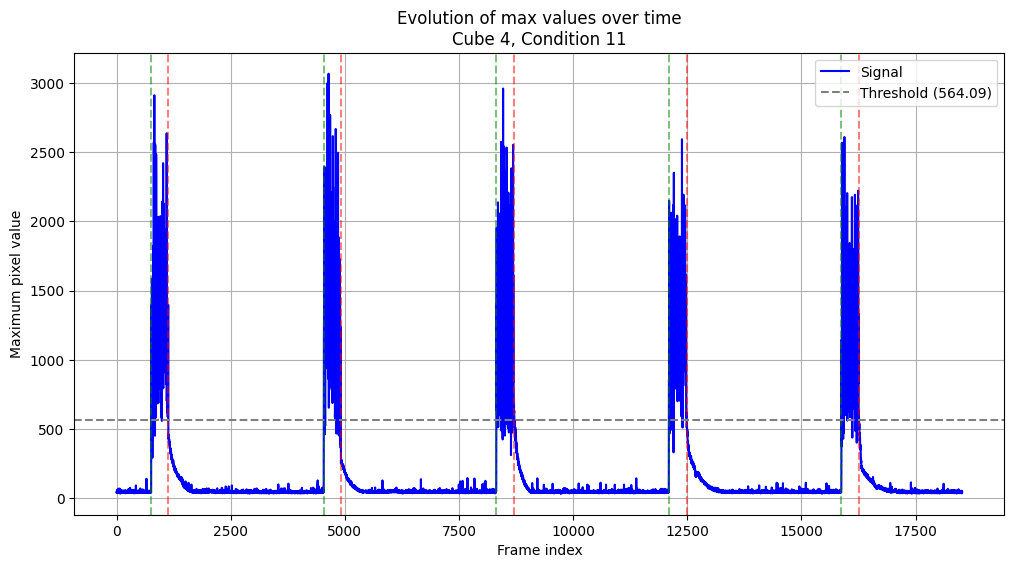

Plotting: Cube=4, Condition=12
99th percentile: 4095.00
1st percentile: 36.00
Calculated threshold: 1253.70
Found 5 segments


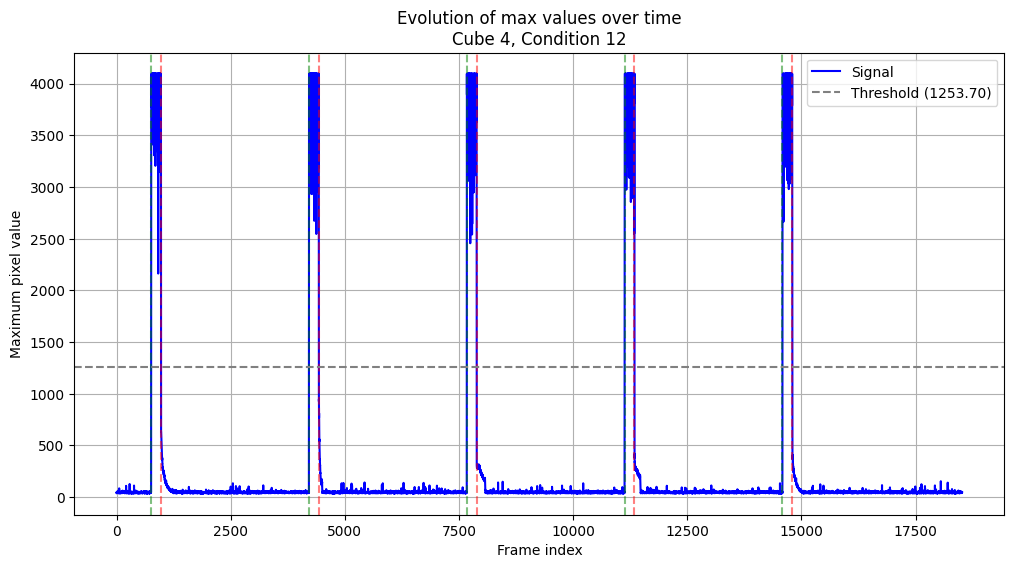

In [9]:
# Loop through all cubes, conditions
for cube in range(1, 5):         # Cubes: 1 to 4
    for condition in range(1, 13):  # Conditions: 1 to 12
            # Check if the data exists before plotting
            if (cube in results and 
                condition in results[cube]):
                
                print(f"Plotting: Cube={cube}, Condition={condition}")
                plot_metric(results, cube=cube, condition=condition, metric_name='max_values')
            else:
                print(f"Skipping: Cube={cube}, Condition={condition} (No Data Found)")


In [5]:
import os
import numpy as np
import tifffile
import pickle
import shutil
from pathlib import Path
import gc
from contextlib import contextmanager

@contextmanager
def memory_guard():
    """Context manager to ensure memory is freed after use"""
    try:
        yield
    finally:
        gc.collect()

def load_video_frames_generator(file_path, start_idx=None, end_idx=None):
    """Generator version of frame loader to reduce memory usage"""
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        return

    with tifffile.TiffFile(file_path) as tif:
        total_frames = len(tif.pages)
        start = start_idx if start_idx is not None else 0
        end = min(end_idx, total_frames-1) if end_idx is not None else total_frames-1
        
        for i in range(start, end + 1):
            yield tif.pages[i].asarray().astype(float)
            
            
def process_single_segment(frame_files, start_frame, end_frame, batch_size=100):
    """Process a single video segment using batched loading"""
    total_frames = end_frame - start_frame + 1
    current_frame = 0
    frames_buffer = []
    
    for file_path in frame_files:
        with memory_guard():
            for frame in load_video_frames_generator(file_path):
                if current_frame >= start_frame and current_frame <= end_frame:
                    frames_buffer.append(frame)
                    
                    if len(frames_buffer) >= batch_size:
                        segment = np.stack(frames_buffer)
                        frames_buffer = []
                        yield segment
                        
                current_frame += 1
                
                if current_frame > end_frame:
                    break
    
    if frames_buffer:
        yield np.stack(frames_buffer)

def get_video_segments(frame_metrics, cube, condition, data_dir="raw_data", metric_name='max_values'):
    """Extract video segments using generators and batched processing"""
    try:
        signal = frame_metrics[cube][condition][metric_name]
    except KeyError:
        print(f"Data not found for cube={cube}, condition={condition}")
        return None
        
    p90 = np.percentile(signal, 99)
    p10 = np.percentile(signal, 1)
    threshold = (p90-p10) * 0.3 + p10
    
    starting, ending = compute_boundaries(signal, threshold)
    
    if len(starting) == 0:
        print(f"No segments found for cube={cube}, condition={condition}")
        return None

    # Collect file paths
    frame_files = []
    for segment in range(6):
        file_path = os.path.join(
            data_dir, 
            f"cube{cube}", 
            f"cube{cube}_C001H001S00{condition:02d}",
            f"cube{cube}_C001H001S00{condition:02d}-{segment:02d}.tif"
        )
        if os.path.exists(file_path):
            frame_files.append(file_path)
    
    return frame_files, starting, ending

def process_videos(frame_metrics, data_dir="raw_data", output_dir="segmented_videos_data", batch_size=100):
    """Process videos with batched loading and incremental saving"""
    base_dir = Path(output_dir)
    if base_dir.exists():
        shutil.rmtree(base_dir)
    base_dir.mkdir(parents=True, exist_ok=True)
    
    metadata = {}
    total_cubes = len(frame_metrics)
    
    try:
        for cube_idx, cube in enumerate(frame_metrics, 1):
            metadata[cube] = {}
            print(f"Processing cube {cube} [{cube_idx}/{total_cubes}]")
            
            for condition in frame_metrics[cube]:
                with memory_guard():
                    result = get_video_segments(
                        frame_metrics,
                        cube,
                        condition,
                        data_dir=data_dir
                    )
                    
                    if result is None:
                        continue
                        
                    frame_files, starting, ending = result
                    metadata[cube][condition] = {}
                    
                    # Create directories
                    cube_dir = base_dir / f"cube_{cube}"
                    cube_dir.mkdir(exist_ok=True)
                    cond_dir = cube_dir / f"condition_{condition}"
                    cond_dir.mkdir(exist_ok=True)
                    
                    # Process each segment
                    for line, (start, end) in enumerate(zip(starting, ending), start=1):
                        video_filename = cond_dir / f"line_{line}.pkl"
                        metadata[cube][condition][line] = str(video_filename.relative_to(base_dir))
                        
                        # Process and save segment in batches
                        with open(video_filename, "wb") as f:
                            first_batch = True
                            segment_frames = []
                            
                            for batch in process_single_segment(frame_files, start, end, batch_size):
                                segment_frames.append(batch)
                                
                                # Save accumulated frames when buffer gets too large
                                if sum(arr.nbytes for arr in segment_frames) > 1e9:  # 1GB threshold
                                    full_segment = np.concatenate(segment_frames, axis=0)
                                    if first_batch:
                                        pickle.dump(full_segment, f)
                                        first_batch = False
                                    segment_frames = []
                                    del full_segment
                                    gc.collect()
                            
                            # Save any remaining frames
                            if segment_frames:
                                final_segment = np.concatenate(segment_frames, axis=0)
                                if first_batch:
                                    pickle.dump(final_segment, f)
                                del final_segment
                                gc.collect()
                
                print(f"Processed Cube {cube}, Condition {condition}")
        
        # Save metadata
        with open(base_dir / "metadata.pkl", "wb") as f:
            pickle.dump(metadata, f)
            
        print("Processing complete!")
        
    except Exception as e:
        print(f"Error during processing: {str(e)}")
        if base_dir.exists():
            shutil.rmtree(base_dir)
        raise

In [6]:
# Process all videos
process_videos(results, data_dir="raw_data", output_dir="segmented_videos_data")

Processing cube 1 [1/4]
Processed Cube 1, Condition 1
Processed Cube 1, Condition 2
Processed Cube 1, Condition 3
Processed Cube 1, Condition 4
Processed Cube 1, Condition 5
Processed Cube 1, Condition 6
Processed Cube 1, Condition 7
Processed Cube 1, Condition 8
Processed Cube 1, Condition 9
Processed Cube 1, Condition 10
Processed Cube 1, Condition 11
Processed Cube 1, Condition 12
Processing cube 2 [2/4]
Processed Cube 2, Condition 1
Processed Cube 2, Condition 2
Processed Cube 2, Condition 3
Processed Cube 2, Condition 4
Processed Cube 2, Condition 5
Processed Cube 2, Condition 6
Processed Cube 2, Condition 7
Processed Cube 2, Condition 8
Processed Cube 2, Condition 9
Processed Cube 2, Condition 10
Processed Cube 2, Condition 11
Processed Cube 2, Condition 12
Processing cube 3 [3/4]
Processed Cube 3, Condition 1
Processed Cube 3, Condition 2
Processed Cube 3, Condition 3
Processed Cube 3, Condition 4
Processed Cube 3, Condition 5
Processed Cube 3, Condition 6
Processed Cube 3, Cond